# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import StandardScaler
import stats
from scipy import stats

In [2]:
import os
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.1'

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
try:
    from pymer4.models import glm, glmer
except:
    from pymer4.models import glm, glmer
    print("pymer4 is installed.")


Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.
C:\Users\asaf4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\rpy2\rinterface\__init__.py:1185: UserWarning: Environment variable "PATH" redefined by R and overriding existing variable. Current: "c:\Users\asaf4\AppData\Local\Microsoft\WindowsApps;c:\Users\asaf4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\Scripts;C:\Python313\Scripts\;C:\Python313\;C:\ffmpeg\bin;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0\;C:\Windows\System32\OpenSSH\;C:\Program Files\dotnet\;C:\Program Files\Git\cmd;C:\Users\asaf4\AppData\Local\Microsoft\WindowsApps;C:\Users\asaf4\AppData\Local\Programs\Microsoft VS Code\bin;C:\Users\asaf4\AppData\Local\Programs\cursor\resources\app\bin;C:\Users\asaf4\AppData\

pymer4 is installed.


# Functions

In [5]:
def plot_and_standardize_distributions(df, exposure_vars,title= None):
    """
    Plot distributions of variables before and after standardization and add standardized columns to dataframe.
    
    Args:
        df (pd.DataFrame): Input dataframe containing the variables to analyze
        exposure_vars (list): List of column names to analyze and standardize
        
    Returns:
        pd.DataFrame: DataFrame with added standardized columns
    """
    # Create figure showing the original distributions of these characteristics
    plt.figure(figsize=(15, 5))
    if title is None:
        plt.suptitle('Distribution of Flower Characteristics Before Standardization', fontsize=14, y=1.05)
    else:
        plt.suptitle(title, fontsize=14, y=1.05)

    # Plot histograms of the raw data
    for i, var in enumerate(exposure_vars):
        plt.subplot(1, len(exposure_vars), i + 1)
        sns.histplot(data=df, x=var, kde=True)
        plt.title(f'{var}')
        plt.xlabel(f'{var} (Original Units)')
        plt.ylabel('Number of Flowers')

    plt.tight_layout()
    plt.show()

    # Standardize the variables to have mean=0 and standard deviation=1
    # This allows comparison between variables measured in different units
    scaler = StandardScaler()
    normalized_cols = [f'{col}_norm_std' for col in exposure_vars]
    df[normalized_cols] = scaler.fit_transform(df[exposure_vars])

    # Create figure showing the standardized distributions
    plt.figure(figsize=(15, 5))
    if title is None:
        plt.suptitle('Distribution of Flower Characteristics After Standardization', fontsize=14, y=1.05)
    else:
        plt.suptitle(title, fontsize=14, y=1.05)

    # Plot histograms of standardized data
    for i, var in enumerate(normalized_cols):
        plt.subplot(1, len(exposure_vars), i + 1)
        sns.histplot(data=df, x=var, kde=True)
        plt.title(f'{exposure_vars[i]}')
        plt.xlabel('Standard Deviations from Mean')
        plt.ylabel('Number of Flowers')
        
        # Add text showing mean and std of original data
        orig_mean = df[exposure_vars[i]].mean()
        orig_std = df[exposure_vars[i]].std()
        plt.text(0.05, 0.95, f'Original Mean: {orig_mean:.2f}\nOriginal Std: {orig_std:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')

    plt.tight_layout()
    plt.show()
    
    return df

In [6]:
def plot_population_treatment_distributions(df, variables_to_plot, population_column='population', treatment_column='treatment', show_stats=False):
    """
    Create box plots, violin plots and print summary statistics for variables across population and treatment groups.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe containing the data
    variables_to_plot : list
        List of variable names to analyze
    population_column : str, optional
        Name of the population column (default: 'population')
    treatment_column : str, optional 
        Name of the treatment column (default: 'treatment')
    show_stats : bool, optional
        Whether to show median and other statistics on the box plots (default: False)
    """
    # Create subplots for each variable, separated by population and treatment
    rows, columns = len(variables_to_plot), 1
    fig, axes = plt.subplots(rows, columns, figsize=(12, 10))
    
    # Convert axes to array if single subplot
    if rows == 1:
        axes = [axes]
    elif rows > 1:
        axes = axes.ravel()

    # Loop through variables and create box plots
    for i, var in enumerate(variables_to_plot):
        # Create box plot with population on x-axis and treatment as hue
        box_plot = sns.boxplot(x=population_column, y=var, hue=treatment_column, data=df, ax=axes[i])
        axes[i].set_title(f'{var} by Population and Treatment')
        axes[i].set_xlabel('Population')
        axes[i].set_ylabel(var)
        
        if show_stats:
            # Calculate and display statistics for each box
            for j, population in enumerate(df[population_column].unique()):
                for k, treatment in enumerate(df[treatment_column].unique()):
                    data = df[(df[population_column] == population) & 
                            (df[treatment_column] == treatment)][var]
                    if len(data) > 0:  # Only add stats if data exists
                        median = data.median()
                        q1 = data.quantile(0.25)
                        q3 = data.quantile(0.75)
                        n = len(data)
                        stats_text = f'n={n}\nmedian={median:.2f}\nQ1={q1:.2f}\nQ3={q3:.2f}'
                        # Position text above each box
                        x_pos = j + (k * 0.8 - 0.4)  # Adjust x position based on box position
                        y_pos = data.mean() 
                        axes[i].text(x_pos, y_pos, stats_text,
                                   horizontalalignment='center',
                                   verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

    # Create violin plots for the same variables
    fig, axes = plt.subplots(rows, columns, figsize=(12, 10))
    
    # Convert axes to array if single subplot
    if rows == 1:
        axes = [axes]
    elif rows > 1:
        axes = axes.ravel()

    for i, var in enumerate(variables_to_plot):
        sns.violinplot(x=population_column, y=var, hue=treatment_column, data=df, ax=axes[i])
        axes[i].set_title(f'{var} by Population and Treatment')
        axes[i].set_xlabel('Population')
        axes[i].set_ylabel(var)

    plt.tight_layout()
    plt.show()

    # Create summary statistics table
    summary_stats = []
    for var in variables_to_plot:
        for pop in df[population_column].unique():
            for treat in df[treatment_column].unique():
                data = df[(df[population_column] == pop) & (df[treatment_column] == treat)][var]
                if len(data) > 0:
                    stats = {
                        'Variable': var,
                        'Population': pop,
                        'Treatment': treat,
                        'Count': len(data),
                        'Mean': data.mean(),
                        'Std': data.std(),
                        'Min': data.min(),
                        'Q1': data.quantile(0.25),
                        'Median': data.median(),
                        'Q3': data.quantile(0.75),
                        'Max': data.max()
                    }
                    summary_stats.append(stats)
    
    # Convert to DataFrame and display
    summary_df = pd.DataFrame(summary_stats)
    display(summary_df.style.format({
        'Mean': '{:.2f}',
        'Std': '{:.2f}',
        'Min': '{:.2f}',
        'Q1': '{:.2f}',
        'Median': '{:.2f}',
        'Q3': '{:.2f}',
        'Max': '{:.2f}'
    }))

In [7]:

def plot_fruit_distribution(df):
    """
    Plot the distribution of fruit presence across treatments and populations.
    
    Args:
        df (pandas.DataFrame): DataFrame containing the columns 'fruit', 'treatment', and 'population'
    """
    # Drop rows where 'fruit' is NaN for visualization purposes
    df_cleaned = df.dropna(subset=['fruit'])

    # Ensure 'fruit' is treated as a categorical variable for plotting
    df_cleaned['fruit'] = df_cleaned['fruit'].astype(int).astype(str)

    # Create the faceted count plot using catplot
    g = sns.catplot(data=df_cleaned, x='treatment', hue='fruit', col='population', 
                    kind='count', height=5, aspect=0.8)
    g.fig.suptitle('Fruit Presence by Treatment and Population', y=1.03)

    # Add numbers on top of each bar
    for ax in g.axes.flat: # Iterate through each subplot
        for p in ax.patches: # Iterate through each bar in the subplot
            if p.get_height() > 0: # Only add text if bar height is greater than 0
                ax.text(p.get_x() + p.get_width() / 2.,    # x-coordinate of text
                        p.get_height(),                   # y-coordinate of text (top of the bar)
                        f'{int(p.get_height())}',         # Text to display (bar height as integer)
                        ha='center',                      # Horizontal alignment
                        va='bottom',                      # Vertical alignment (place text just above the bar)
                        fontsize=9,                       # Font size
                        color='black')                    # Text color

    plt.tight_layout()
    plt.show()

    # Print counts for each combination
    print("Counts grouped by treatment, then population, then fruit:")
    print(df_cleaned.groupby(['treatment', 'population', 'fruit']).size().unstack(fill_value=0))

In [8]:
def plot_top_k_genotypes_boxplot(df, variable_name='flower_size_norm', k=15):
    """
    Create boxplots showing distribution of a variable for top k genotypes by count,
    separated by population and treatment.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe containing genotype_id and variable to plot
    variable_name : str, default='flower_size_norm'
        Name of variable to plot on y-axis
    k : int, default=15
        Number of top genotypes to include per group
    """
    # Create figure with subplots for each population-treatment combination
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define the three groups
    groups = [
        ('KUR', 'CONTROL'),
        ('NET', 'CONTROL'),
        ('NET', 'TREATMENT')
    ]
    
    for idx, (pop, treat) in enumerate(groups):
        # Filter data for this population-treatment combination
        df_group = df[(df['population'] == pop) & (df['treatment'] == treat)]
        
        # Get top k genotypes by total count
        genotype_counts = df_group['genotype_id'].value_counts()
        top_k_genotypes = genotype_counts.nlargest(k).index
        
        # Filter data for top k genotypes
        df_topk = df_group[df_group['genotype_id'].isin(top_k_genotypes)]
        
        # Sort genotypes by their total count
        df_topk['genotype_order'] = df_topk['genotype_id'].map(genotype_counts)
        df_topk = df_topk.sort_values('genotype_order', ascending=False)
        
        # Create box plot in corresponding subplot
        if treat == 'TREATMENT':
            sns.boxplot(data=df_topk, x='genotype_id', y=variable_name, ax=axes[idx], color='orange')
        else:
            sns.boxplot(data=df_topk, x='genotype_id', y=variable_name, ax=axes[idx])
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
        axes[idx].set_title(f'{pop} - {treat}')
        axes[idx].set_xlabel('Genotype ID')
        
        # Only show y-label for first subplot
        if idx == 0:
            axes[idx].set_ylabel(variable_name)
        else:
            axes[idx].set_ylabel('')

    plt.suptitle(f'{variable_name} Distribution by Top {k} Genotypes per Group')
    plt.tight_layout()
    plt.show()

In [9]:
def plot_fruit_success_by_genotype(df, k=15):
    """
    Plot stacked bar charts showing fruit success/failure counts for top k genotypes per population-treatment group.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe containing genotype_id, population, treatment and fruit columns
    k : int, default=15
        Number of top genotypes to include per group
    """
    # Create figure with subplots for each population-treatment combination
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Define the three groups
    groups = [
        ('KUR', 'CONTROL'),
        ('NET', 'CONTROL'), 
        ('NET', 'TREATMENT')
    ]

    for idx, (pop, treat) in enumerate(groups):
        # Filter data for this population-treatment combination
        df_group = df[(df['population'] == pop) & (df['treatment'] == treat)]
        
        # Get top k genotypes for this group
        top_k_genotypes = df_group['genotype_id'].value_counts().nlargest(k).index
        
        # Filter data for top k genotypes
        df_topk = df_group[df_group['genotype_id'].isin(top_k_genotypes)]
        
        # Calculate fruit success/failure counts per genotype
        fruit_counts = df_topk.groupby(['genotype_id', 'fruit']).size().unstack(fill_value=0)
        
        # Sort by total count descending
        total_counts = fruit_counts.sum(axis=1)
        fruit_counts = fruit_counts.loc[total_counts.sort_values(ascending=False).index]
        
        # Create stacked bar plot
        fruit_counts.plot(kind='bar', stacked=True, ax=axes[idx], 
                         color=['orange', 'C0'], # 0=orange, 1=default blue
                         width=0.8)
        
        axes[idx].set_title(f'{pop} - {treat}')
        axes[idx].set_xlabel('Genotype ID')
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
        
        # Only show y-label for first subplot
        if idx == 0:
            axes[idx].set_ylabel('Count')
        else:
            axes[idx].set_ylabel('')
            
        # Add legend
        axes[idx].legend(['No Fruit', 'Has Fruit'])

    plt.suptitle(f'Fruit Success Distribution by Top {k} Genotypes per Group')
    plt.tight_layout()
    plt.show()


# Exploratory Data Analysis

## 2024 - Flower Based

### Load data

In [10]:
csv_output_path = r'..\data\2024\Data_Per_flower_2024_final.csv'
df = pd.read_csv(csv_output_path)
df.drop(columns=['seed_weight'],inplace=True)
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower_size,tunnel_length,entr_length,entr_height,tunnel_volume_cm,bp_area,fruit,seed
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0
1,2,2024-02-07,1,NET,BROWN,N185,185.1,SUPP,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,298,2024-03-13,36,KUR,BLUE,K222,222.3,CONTROL,51.4,46.9,1.095949,24.1066,24.6,12.2,8.0,2.400960,6.464,NaN,NaN
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0


- Talk with Prittee about treatment in Yavne

In [11]:
df = df.drop(df[(df['population']=='KUR') & (df['treatment']=='SUPP')].index)
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower_size,tunnel_length,entr_length,entr_height,tunnel_volume_cm,bp_area,fruit,seed
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0
1,2,2024-02-07,1,NET,BROWN,N185,185.1,SUPP,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,298,2024-03-13,36,KUR,BLUE,K222,222.3,CONTROL,51.4,46.9,1.095949,24.1066,24.6,12.2,8.0,2.400960,6.464,NaN,NaN
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0


In [12]:
# Rename columns to include units
df = df.rename(columns={
    'Flower_size': 'Flower Size (cm^2)',
    'tunnel_volume_cm': 'Tunnel Volume (cm^3)', 
    'bp_area': 'Black Patch Area (cm^2)'
})
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0
1,2,2024-02-07,1,NET,BROWN,N185,185.1,SUPP,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,298,2024-03-13,36,KUR,BLUE,K222,222.3,CONTROL,51.4,46.9,1.095949,24.1066,24.6,12.2,8.0,2.400960,6.464,NaN,NaN
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0


### Quantities

In [13]:
# Rename SUPP to TREATMENT in treatment column
df['treatment'] = df['treatment'].replace('SUPP', 'TREATMENT')

df.value_counts(['population','treatment'])

population  treatment
KUR         CONTROL      171
NET         CONTROL       81
            TREATMENT     47
Name: count, dtype: int64

### Exposure Variables Distributions

In [14]:
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,Flower Size (cm^2),tunnel_length,entr_length,entr_height,Tunnel Volume (cm^3),Black Patch Area (cm^2),fruit,seed
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,1.234356,81.9890,34.1,14.1,8.9,4.279209,8.166,1.0,8.0
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,1.088083,64.8480,33.6,11.6,7.8,3.040128,7.224,1.0,55.0
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.469580,7.652,1.0,39.0
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.610160,7.958,0.0,0.0
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,298,2024-03-13,36,KUR,BLUE,K222,222.3,CONTROL,51.4,46.9,1.095949,24.1066,24.6,12.2,8.0,2.400960,6.464,NaN,NaN
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.913460,5.452,0.0,0.0
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,1.164436,31.8507,30.7,13.5,5.8,2.403810,7.456,0.0,0.0


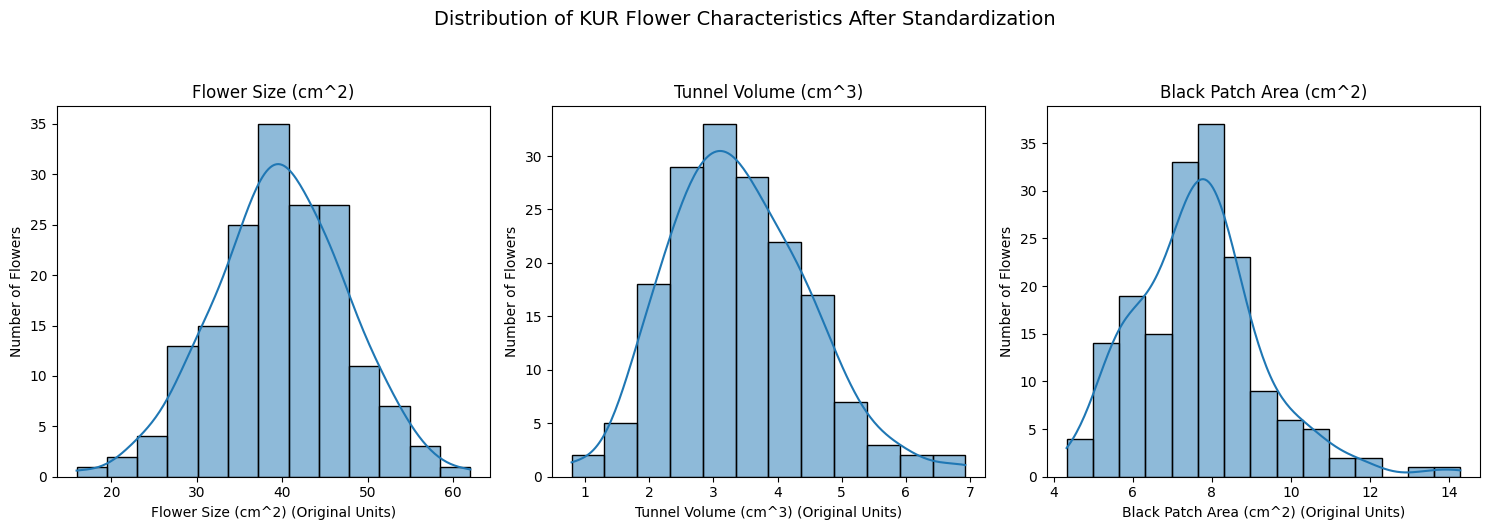

C:\Users\asaf4\AppData\Local\Temp\ipykernel_852\3991702448.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[normalized_cols] = scaler.fit_transform(df[exposure_vars])
C:\Users\asaf4\AppData\Local\Temp\ipykernel_852\3991702448.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[normalized_cols] = scaler.fit_transform(df[exposure_vars])
C:\Users\asaf4\AppData\Local\Temp\ipykernel_852\3991702448.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

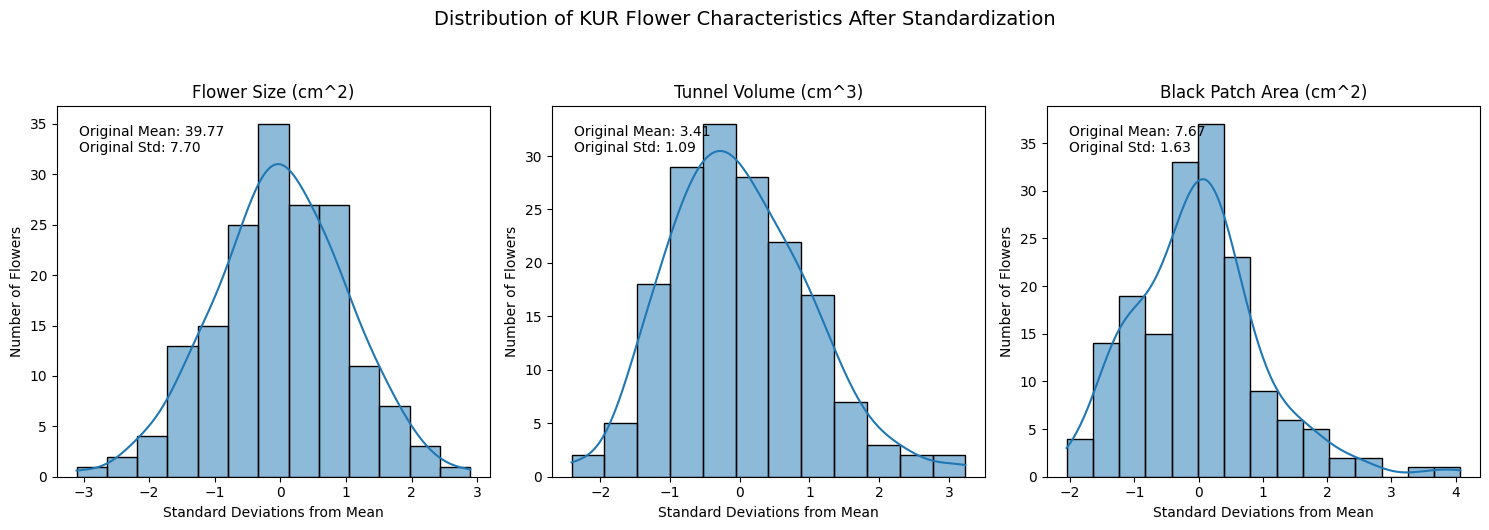

In [15]:
exposure_vars = ['Flower Size (cm^2)','Tunnel Volume (cm^3)', 'Black Patch Area (cm^2)']
df_kur = df[df['population'] == 'KUR']
title = 'Distribution of KUR Flower Characteristics After Standardization'
_ = plot_and_standardize_distributions(df_kur, exposure_vars,title=title)


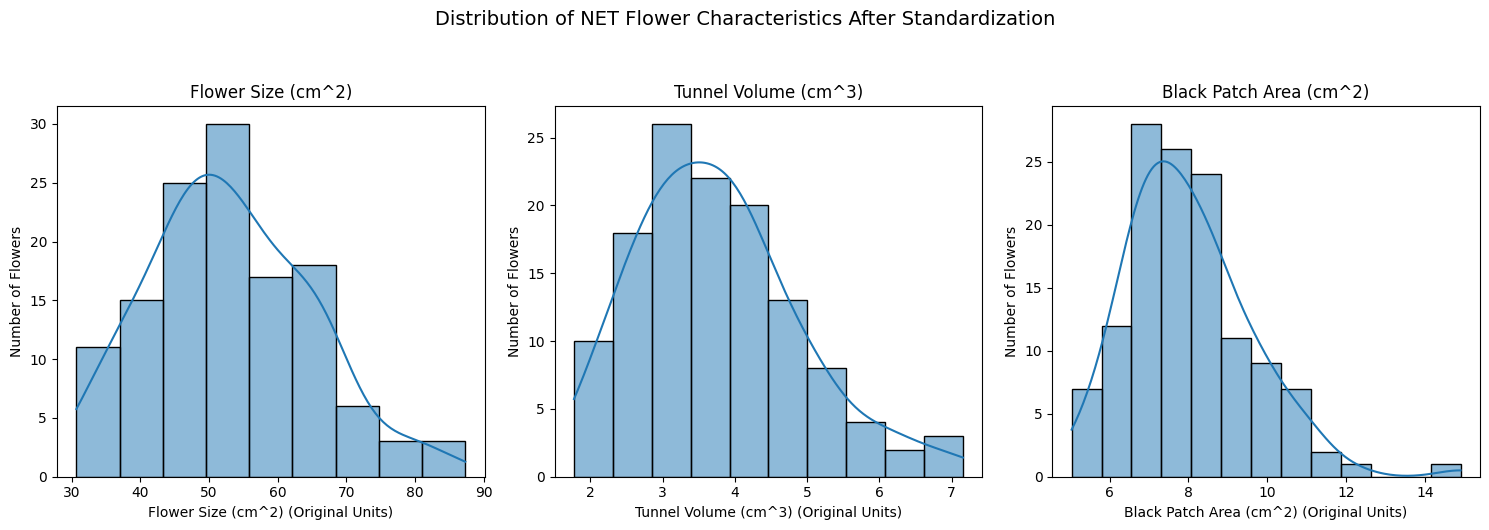

C:\Users\asaf4\AppData\Local\Temp\ipykernel_852\3991702448.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[normalized_cols] = scaler.fit_transform(df[exposure_vars])
C:\Users\asaf4\AppData\Local\Temp\ipykernel_852\3991702448.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[normalized_cols] = scaler.fit_transform(df[exposure_vars])
C:\Users\asaf4\AppData\Local\Temp\ipykernel_852\3991702448.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

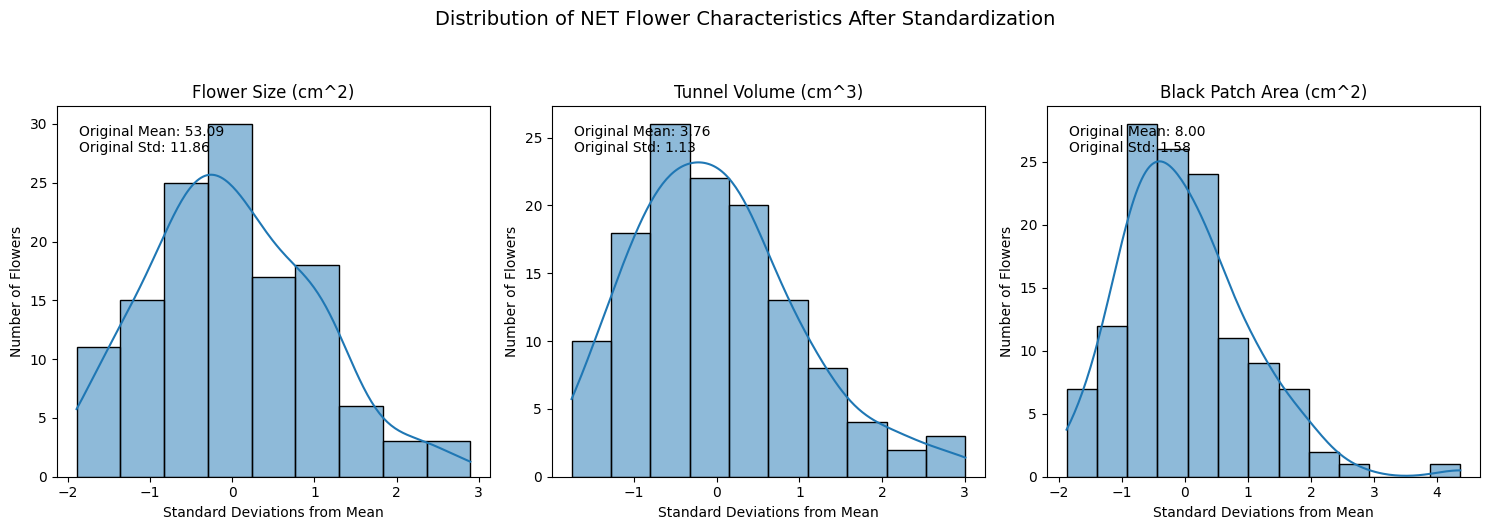

In [16]:
df_net = df[df['population'] == 'NET']
title = 'Distribution of NET Flower Characteristics After Standardization'
_ = plot_and_standardize_distributions(df_net, exposure_vars, title)

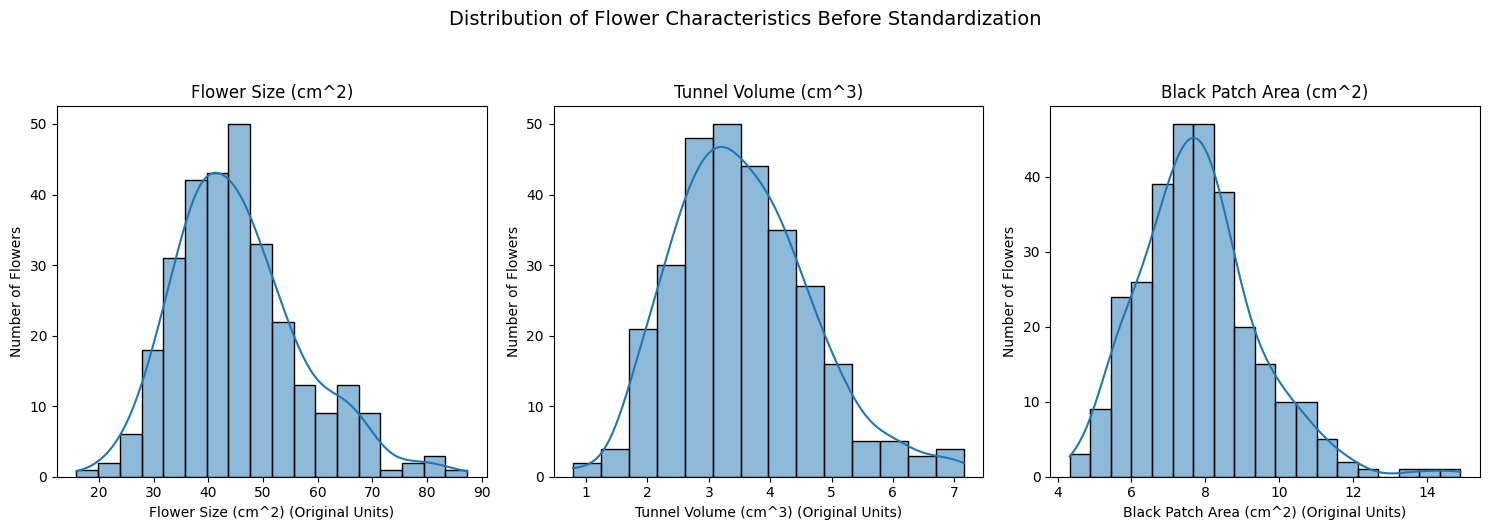

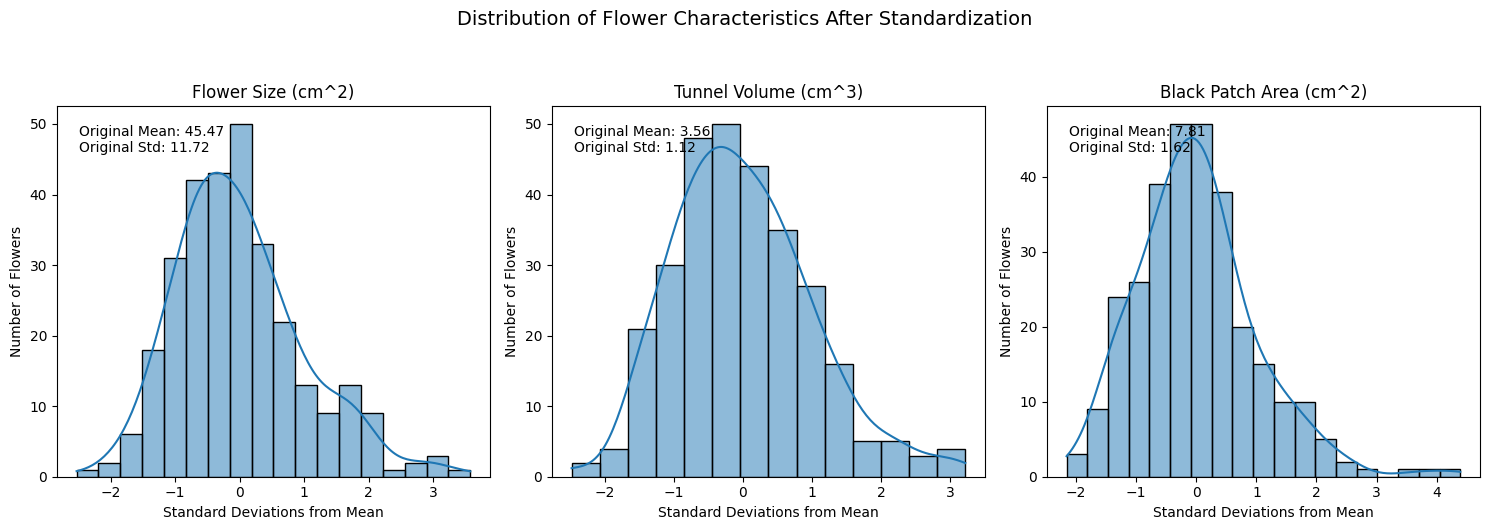

In [17]:
df = plot_and_standardize_distributions(df, exposure_vars)

### Correlation Heat map

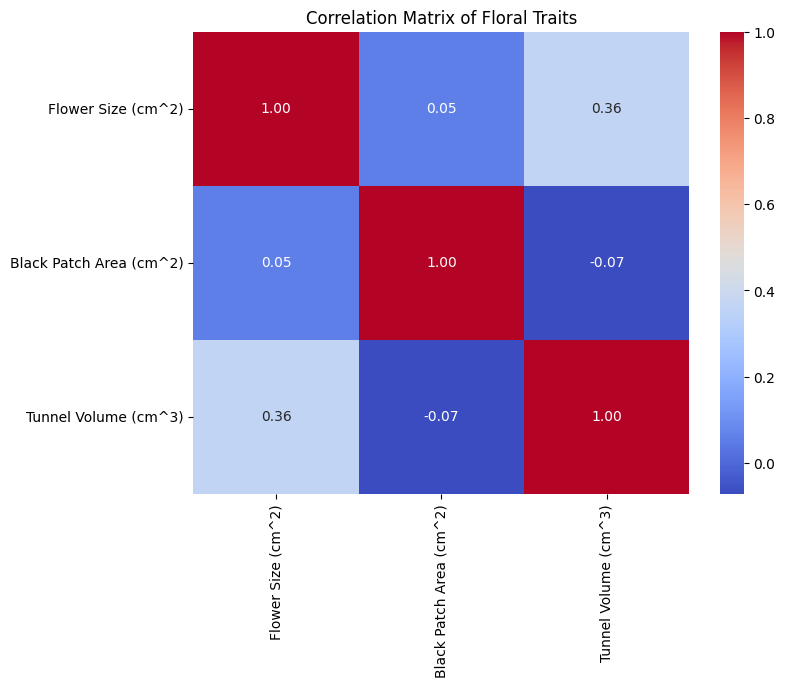

In [18]:
# Calculate and display the correlation matrix for floral traits
floral_traits = ['Flower Size (cm^2)', 'Black Patch Area (cm^2)', 'Tunnel Volume (cm^3)']
# Make sure your DataFrame is named 'df' or change it in the line below
correlation_matrix = df[floral_traits].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Floral Traits')
plt.show()

In [19]:
df.columns

Index(['S.No.', 'date', 'day', 'population', 'area', 'genotype_id',
       'Flower_id', 'treatment', 'length_mm', 'width_mm', 'ratio_len_wid',
       'Flower Size (cm^2)', 'tunnel_length', 'entr_length', 'entr_height',
       'Tunnel Volume (cm^3)', 'Black Patch Area (cm^2)', 'fruit', 'seed',
       'Flower Size (cm^2)_norm_std', 'Tunnel Volume (cm^3)_norm_std',
       'Black Patch Area (cm^2)_norm_std'],
      dtype='object')

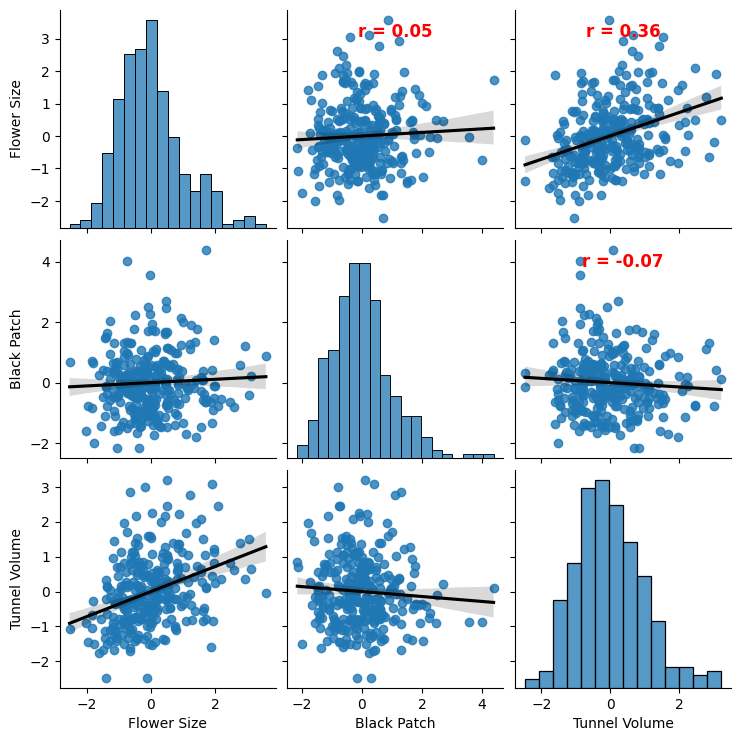

In [20]:
# Scatter plot matrix (pairplot) of all floral traits against each other, with correlation lines
floral_traits = ['Flower Size (cm^2)_norm_std', 'Black Patch Area (cm^2)_norm_std', 'Tunnel Volume (cm^3)_norm_std']
short_names = {
    'Flower Size (cm^2)_norm_std': 'Flower Size',
    'Black Patch Area (cm^2)_norm_std': 'Black Patch',
    'Tunnel Volume (cm^3)_norm_std': 'Tunnel Volume'
}

# Rename columns for plotting
df_short = df[floral_traits].rename(columns=short_names)
floral_traits_short = list(short_names.values())
corr_matrix_short = df_short.corr()

g = sns.pairplot(df_short, diag_kind='hist', kind='reg',
                 plot_kws={'line_kws':{'color':'black'}})

for i, var1 in enumerate(floral_traits_short):
    for j, var2 in enumerate(floral_traits_short):
        if i < j:
            ax = g.axes[i, j]
            corr = corr_matrix_short.loc[var2, var1]
            ax.annotate(f'r = {corr:.2f}', xy=(0.5, 0.9), xycoords='axes fraction',
                        ha='center', va='center', fontsize=12, fontweight='bold', color='red')

# plt.suptitle('Scatter Plot Matrix of Floral Traits (Standardized) with Correlation Lines and Coefficients', y=1.02)
plt.show()


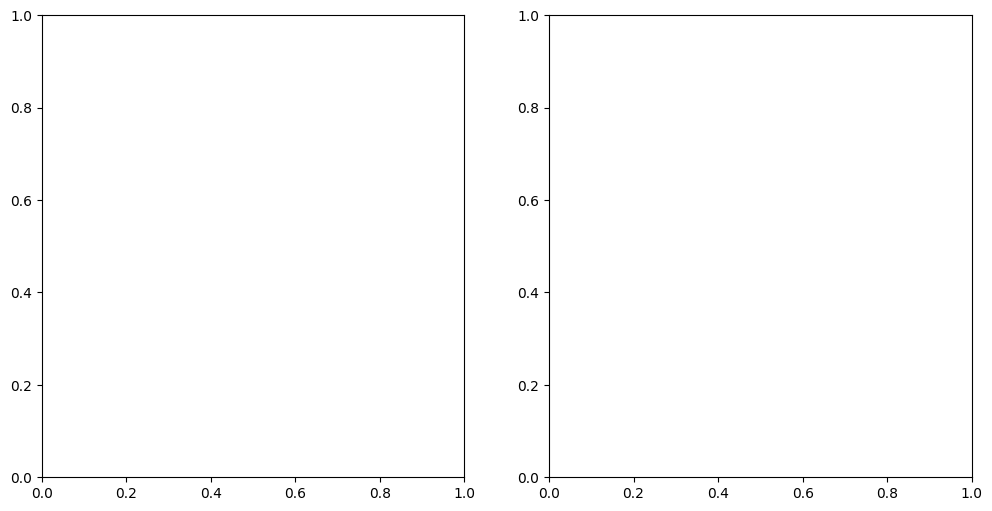

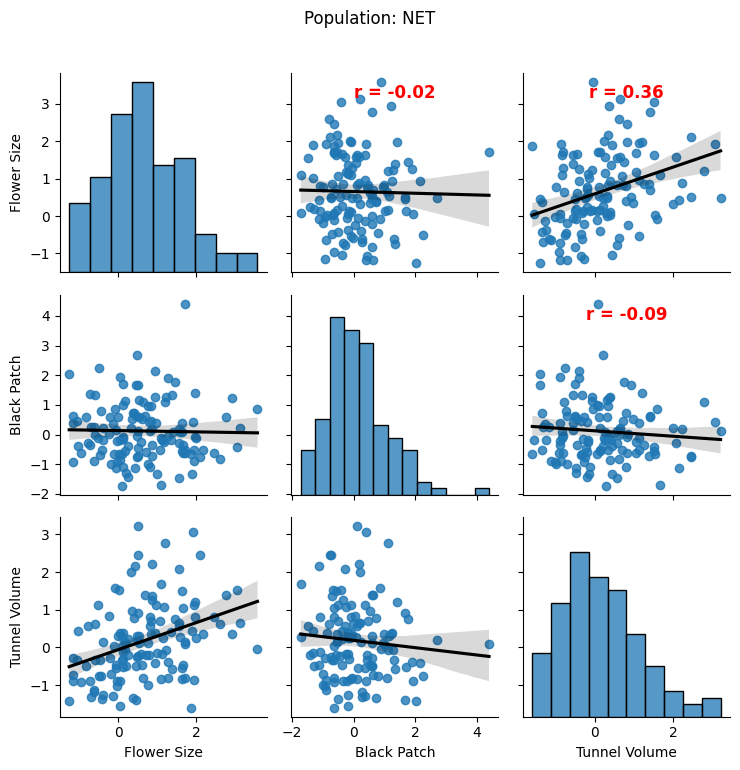

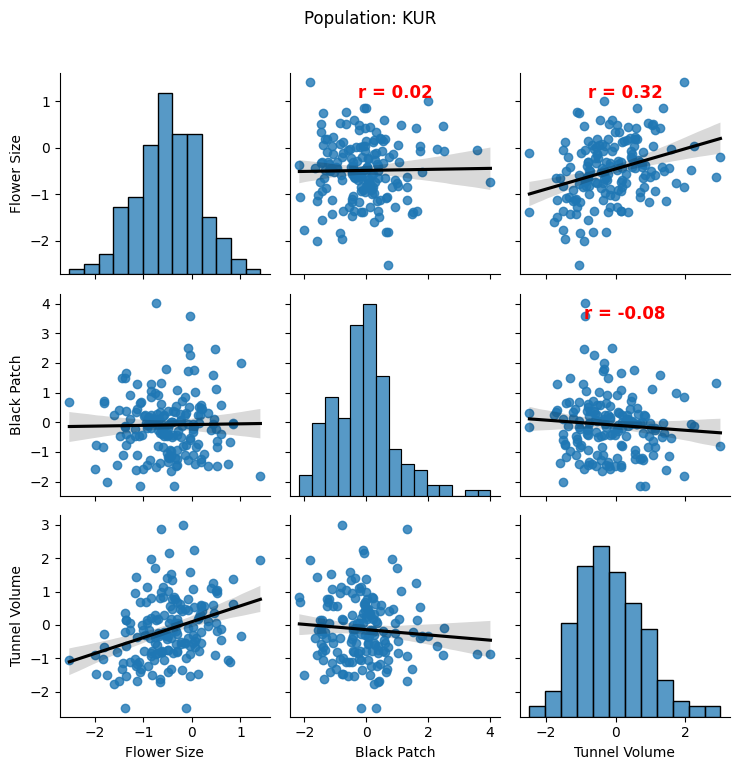

<Figure size 640x480 with 0 Axes>

In [21]:
# Scatter plot matrix (pairplot) of all floral traits against each other, with correlation lines
# Do this separately for each population, and show the correlation coefficients within each population
# Make the plots as subplots on 2 columns

import math

floral_traits = ['Flower Size (cm^2)_norm_std', 'Black Patch Area (cm^2)_norm_std', 'Tunnel Volume (cm^3)_norm_std']
short_names = {
    'Flower Size (cm^2)_norm_std': 'Flower Size',
    'Black Patch Area (cm^2)_norm_std': 'Black Patch',
    'Tunnel Volume (cm^3)_norm_std': 'Tunnel Volume'
}

populations = df['population'].unique()
n_pops = len(populations)
ncols = 2
nrows = math.ceil(n_pops / ncols)

# For each population, create a pairplot and show it as a subplot
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6 * nrows))
axes = axes.flatten() if n_pops > 1 else [axes]

for idx, pop in enumerate(populations):
    df_pop = df[df['population'] == pop]
    df_short = df_pop[floral_traits].rename(columns=short_names)
    floral_traits_short = list(short_names.values())
    corr_matrix_short = df_short.corr()

    # Create pairplot for this population
    g = sns.pairplot(df_short, diag_kind='hist', kind='reg',
                     plot_kws={'line_kws':{'color':'black'}})

    # Annotate correlation coefficients
    for i, var1 in enumerate(floral_traits_short):
        for j, var2 in enumerate(floral_traits_short):
            if i < j:
                ax = g.axes[i, j]
                corr = corr_matrix_short.loc[var2, var1]
                ax.annotate(f'r = {corr:.2f}', xy=(0.5, 0.9), xycoords='axes fraction',
                            ha='center', va='center', fontsize=12, fontweight='bold', color='red')

    # Instead of drawing the pairplot as an image, just show it directly and move to the next subplot
    g.fig.suptitle(f'Population: {pop}', y=1.02)
    g.fig.tight_layout()
    plt.show()
    plt.close(g.fig)  # Close the pairplot figure to avoid extra windows

# Hide any unused subplots (if any)
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### Missing values

In [22]:
df_na = df[df.isna().any(axis=1)]
df_na[['population', 'genotype_id', 'treatment', 'Flower Size (cm^2)', 'Black Patch Area (cm^2)', 'Tunnel Volume (cm^3)', 'fruit', 'seed']].style.highlight_null(color='yellow').set_properties(**{'text-align': 'center'})

,population,genotype_id,treatment,Flower Size (cm^2),Black Patch Area (cm^2),Tunnel Volume (cm^3),fruit,seed
19,NET,N187,CONTROL,62.013100,7.956000,nan,0.000000,0.000000
38,NET,N190,CONTROL,44.118300,6.774000,3.611496,1.000000,nan
83,NET,N196,TREATMENT,55.272000,8.540000,4.355472,1.000000,nan
92,NET,N198,TREATMENT,64.616000,8.425000,2.948670,1.000000,nan
93,NET,N198,TREATMENT,65.521800,14.897000,3.656832,1.000000,nan
103,NET,N111,TREATMENT,36.838500,9.997000,nan,0.000000,0.000000
114,NET,N188,CONTROL,74.181900,6.784000,4.466880,1.000000,nan
191,KUR,K187,CONTROL,44.742600,8.642000,nan,0.000000,0.000000
245,KUR,K197,CONTROL,39.433800,6.156000,nan,1.000000,23.000000
268,KUR,K159,CONTROL,28.229600,7.046000,nan,0.000000,0.000000


In [23]:
df.columns

Index(['S.No.', 'date', 'day', 'population', 'area', 'genotype_id',
       'Flower_id', 'treatment', 'length_mm', 'width_mm', 'ratio_len_wid',
       'Flower Size (cm^2)', 'tunnel_length', 'entr_length', 'entr_height',
       'Tunnel Volume (cm^3)', 'Black Patch Area (cm^2)', 'fruit', 'seed',
       'Flower Size (cm^2)_norm_std', 'Tunnel Volume (cm^3)_norm_std',
       'Black Patch Area (cm^2)_norm_std'],
      dtype='object')

### Examining exposure variables across population and treatment

In [24]:
# Rename variables to be more concise
df = df.rename(columns={
    'Flower Size (cm^2)': 'flower_size',
    'Black Patch Area (cm^2)': 'black_patch', 
    'Tunnel Volume (cm^3)': 'tunnel_volume',
    'Flower Size (cm^2)_norm_std': 'flower_size_norm',
    'Black Patch Area (cm^2)_norm_std': 'black_patch_norm',
    'Tunnel Volume (cm^3)_norm_std': 'tunnel_volume_norm'
})

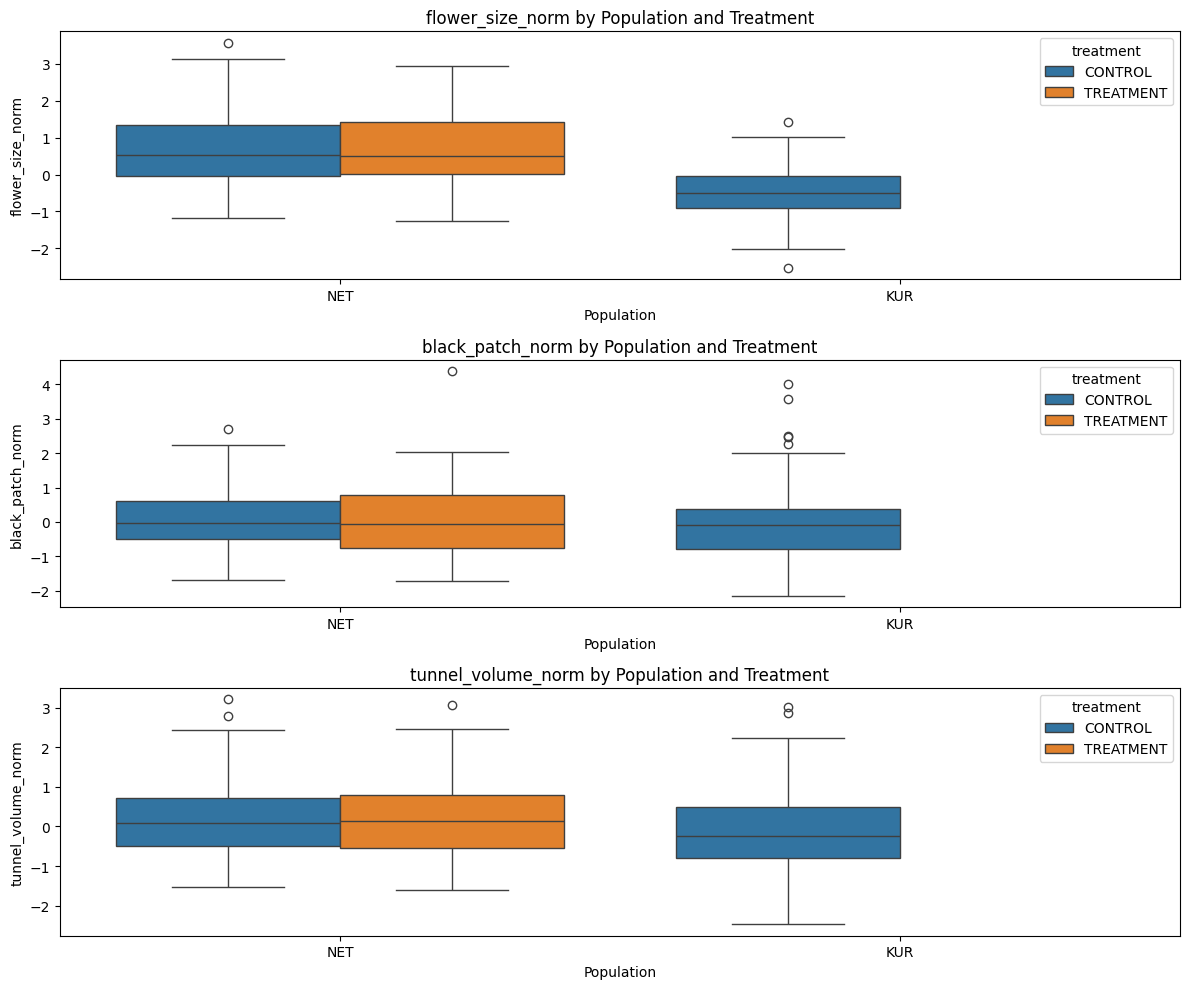

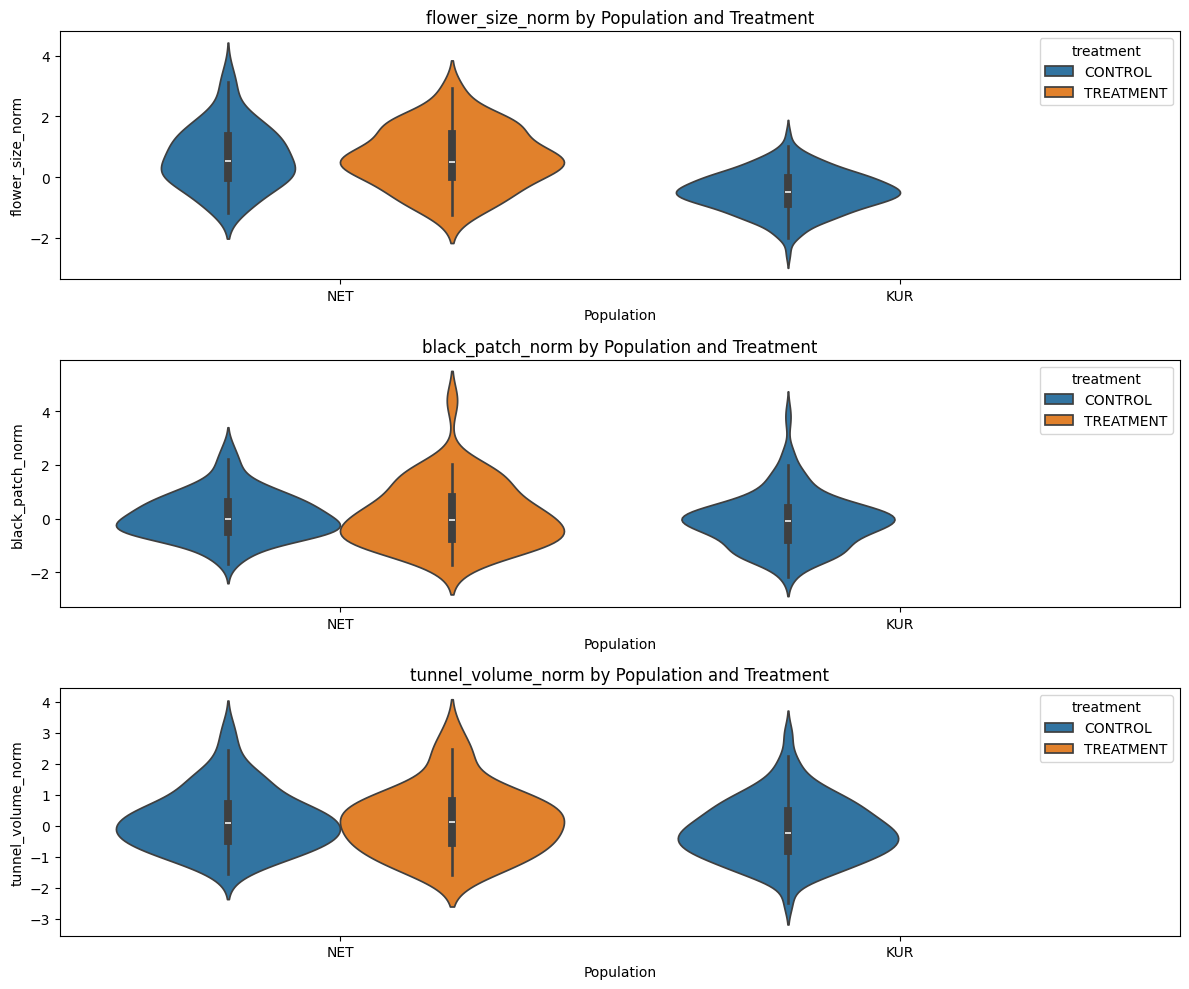

,Variable,Population,Treatment,Count,Mean,Std,Min,Q1,Median,Q3,Max
0,flower_size_norm,NET,CONTROL,81,0.67,1.03,-1.17,-0.04,0.54,1.35,3.58
1,flower_size_norm,NET,TREATMENT,47,0.63,0.99,-1.26,0.01,0.51,1.42,2.93
2,flower_size_norm,KUR,CONTROL,171,-0.49,0.66,-2.53,-0.90,-0.49,-0.04,1.41
3,black_patch_norm,NET,CONTROL,81,0.11,0.85,-1.69,-0.51,-0.02,0.61,2.69
4,black_patch_norm,NET,TREATMENT,47,0.13,1.19,-1.72,-0.74,-0.05,0.79,4.39
5,black_patch_norm,KUR,CONTROL,171,-0.09,1.01,-2.16,-0.78,-0.10,0.38,4.01
6,tunnel_volume_norm,NET,CONTROL,81,0.19,0.98,-1.54,-0.48,0.08,0.71,3.22
7,tunnel_volume_norm,NET,TREATMENT,47,0.16,1.08,-1.60,-0.55,0.13,0.78,3.07
8,tunnel_volume_norm,KUR,CONTROL,171,-0.13,0.97,-2.48,-0.81,-0.24,0.49,3.01


In [25]:
variables_to_plot = ['flower_size_norm', 'black_patch_norm', 'tunnel_volume_norm']

plot_population_treatment_distributions(df, variables_to_plot)


### Examining Outcome variables across population and treatment

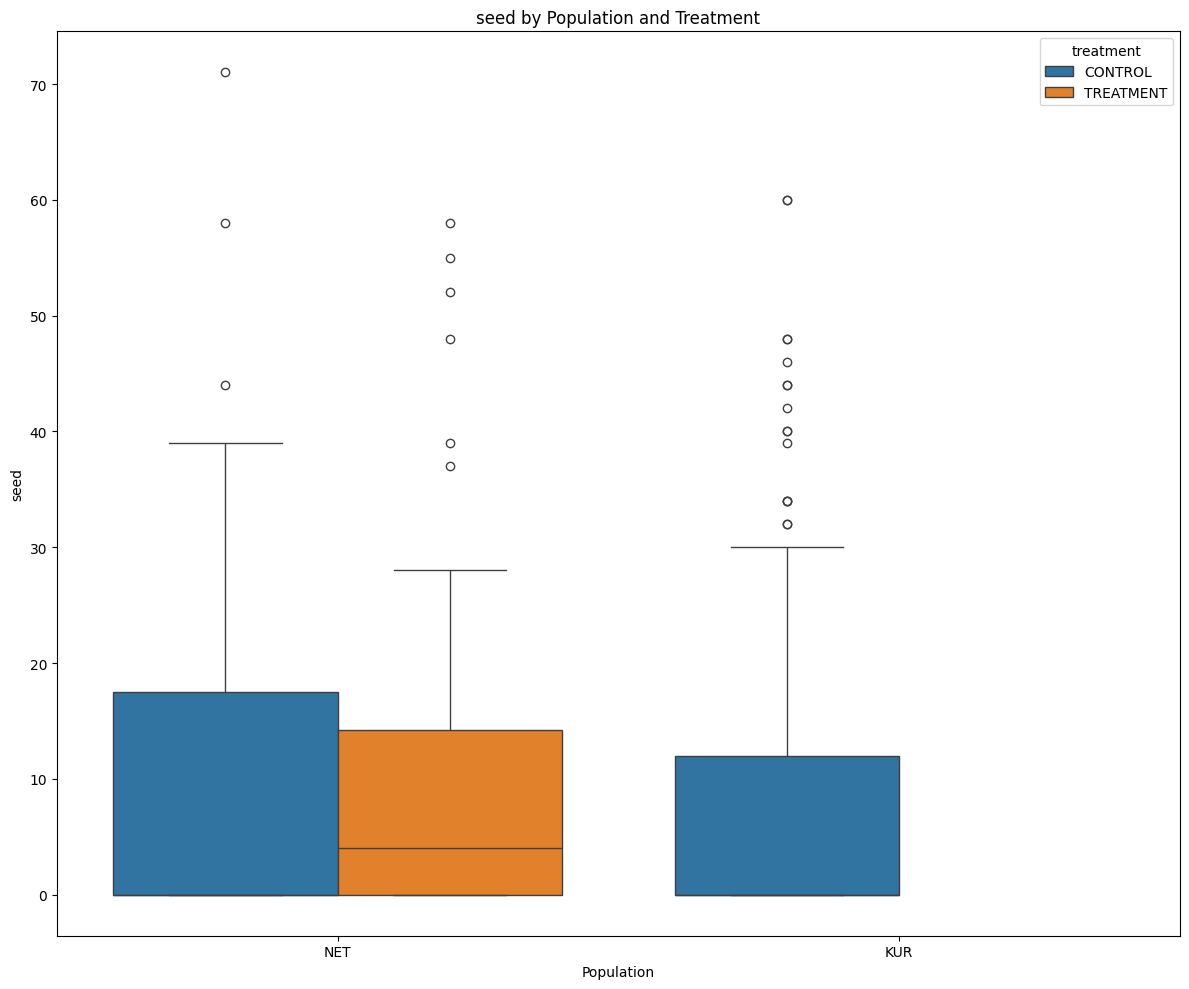

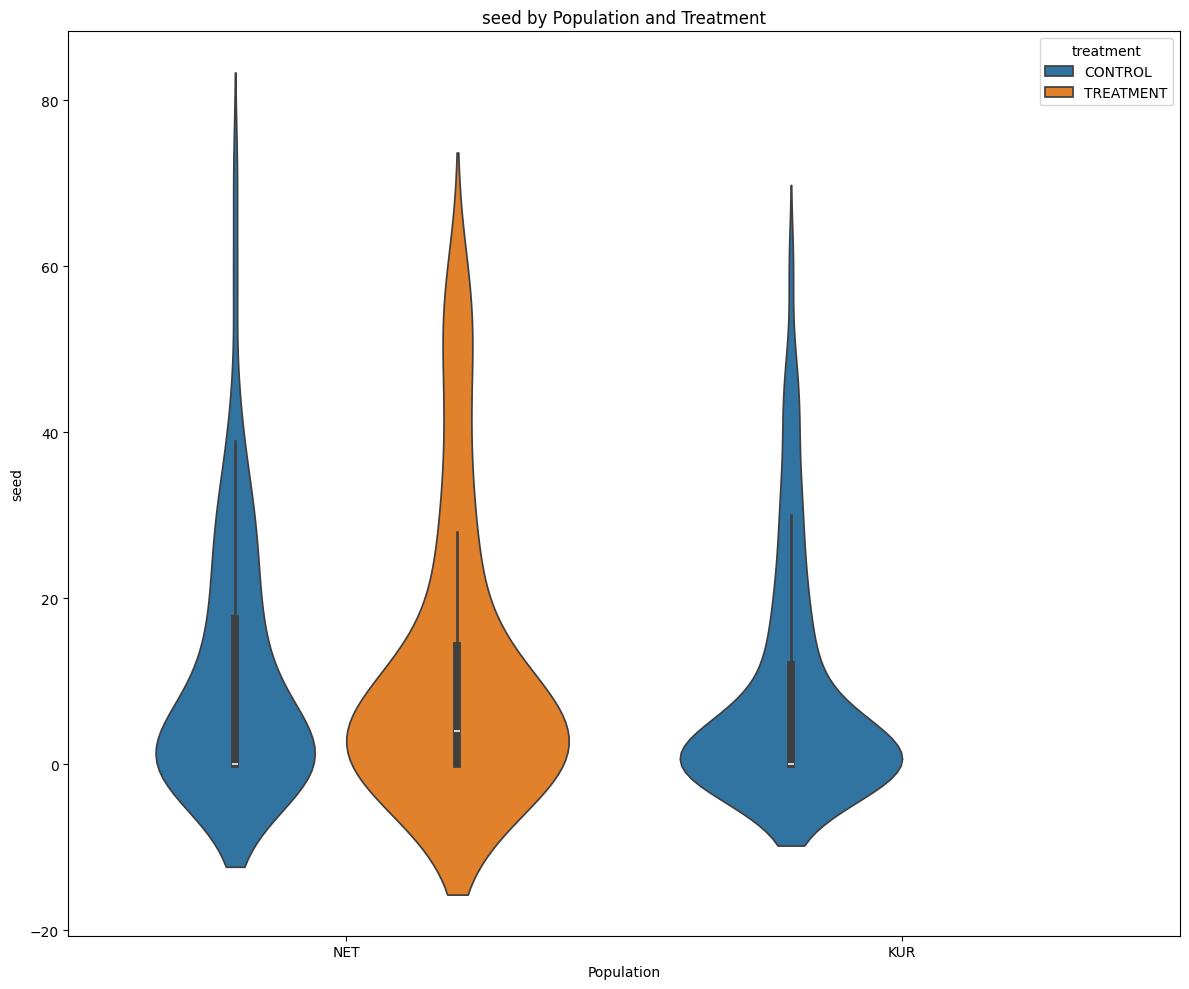

,Variable,Population,Treatment,Count,Mean,Std,Min,Q1,Median,Q3,Max
0,seed,NET,CONTROL,81,10.46,14.78,0.00,0.00,0.00,17.50,71.00
1,seed,NET,TREATMENT,47,11.50,16.73,0.00,0.00,4.00,14.25,58.00
2,seed,KUR,CONTROL,171,8.33,13.63,0.00,0.00,0.00,12.00,60.00


In [26]:
variables_to_plot = ['seed']

plot_population_treatment_distributions(df, variables_to_plot,show_stats=False)


C:\Users\asaf4\AppData\Local\Temp\ipykernel_852\3410734422.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['fruit'] = df_cleaned['fruit'].astype(int).astype(str)


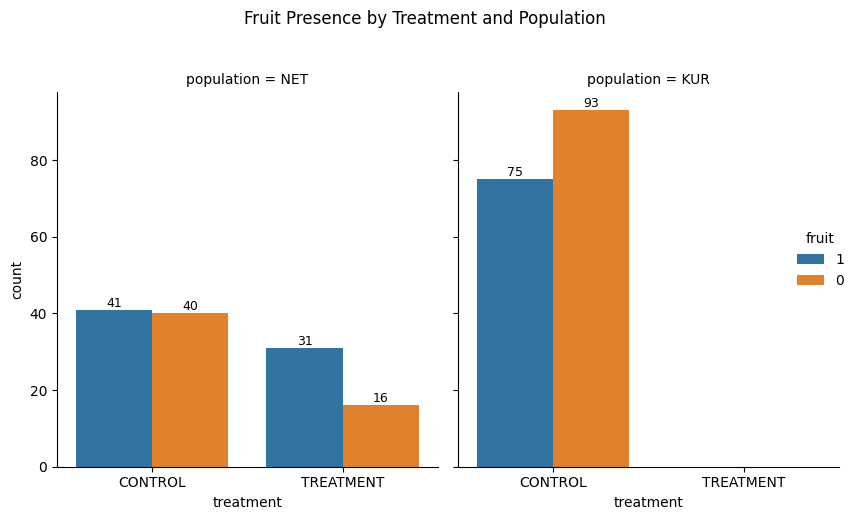

Counts grouped by treatment, then population, then fruit:
fruit                  0   1
treatment population        
CONTROL   KUR         93  75
          NET         40  41
TREATMENT NET         16  31


In [27]:
plot_fruit_distribution(df)

In [28]:
# Create a contingency table for fruit presence by population and treatment (absolute counts)
fruit_ct_counts = pd.crosstab(
    [df['population'], df['treatment']],
    df['fruit'],
    margins=True
)

# Create a contingency table for fruit presence by population and treatment (percentages)
fruit_ct_perc = pd.crosstab(
    [df['population'], df['treatment']],
    df['fruit'],
    margins=True,
    normalize='index'
)

# Remove the 'All' row for cleaner visualization
fruit_ct_counts = fruit_ct_counts.drop('All', errors='ignore')
fruit_ct_perc = fruit_ct_perc.drop('All', errors='ignore')

# Define a formal and visually appealing style for the tables
def style_fruit_table(df, caption, is_percentage=False):
    styler = df.style.set_caption(caption)\
        .set_table_styles([
            {'selector': 'caption', 'props': [('color', '#333'), ('font-size', '18px'), ('font-weight', 'bold'), ('text-align', 'center'), ('margin-bottom', '10px')]},
            {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', '#222'), ('font-size', '15px'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('font-size', '14px')]}
        ])\
        .background_gradient(cmap="Blues", axis=None)
    if is_percentage:
        styler = styler.format("{:.2%}")
    else:
        styler = styler.format("{:.0f}")
    return styler

# Display the table as absolute counts with enhanced style
display(style_fruit_table(fruit_ct_counts, "Absolute Count of Fruit Presence by Population and Treatment"))

# Display the table as percentages with enhanced style
display(style_fruit_table(fruit_ct_perc, "Proportion of Fruit Presence by Population and Treatment", is_percentage=True))


C:\Users\asaf4\AppData\Local\Temp\ipykernel_852\1896081742.py:17: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  fruit_ct_counts = fruit_ct_counts.drop('All', errors='ignore')
C:\Users\asaf4\AppData\Local\Temp\ipykernel_852\1896081742.py:18: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  fruit_ct_perc = fruit_ct_perc.drop('All', errors='ignore')


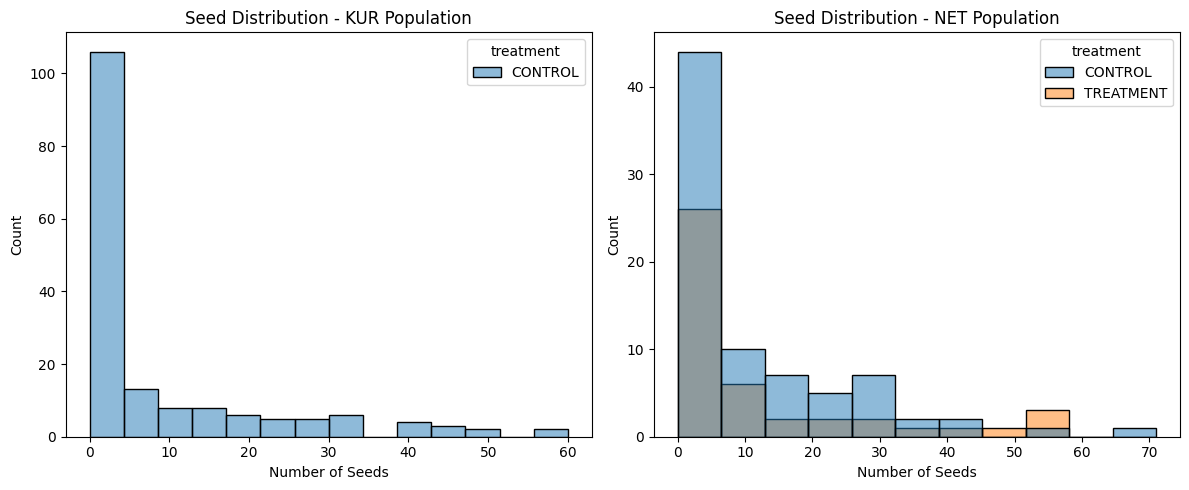

In [ ]:
# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# First subplot for histogram
plt.subplot(1, 2, 1)
sns.histplot(data=df[df['population']=='KUR'], x='seed', hue='treatment', multiple="layer", alpha=0.5)
plt.title('Seed Distribution - KUR Population')
plt.xlabel('Number of Seeds')
plt.ylabel('Count')

# Second subplot for histogram
plt.subplot(1, 2, 2)
sns.histplot(data=df[df['population']=='NET'], x='seed', hue='treatment', multiple="layer", alpha=0.5)
plt.title('Seed Distribution - NET Population') 
plt.xlabel('Number of Seeds')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


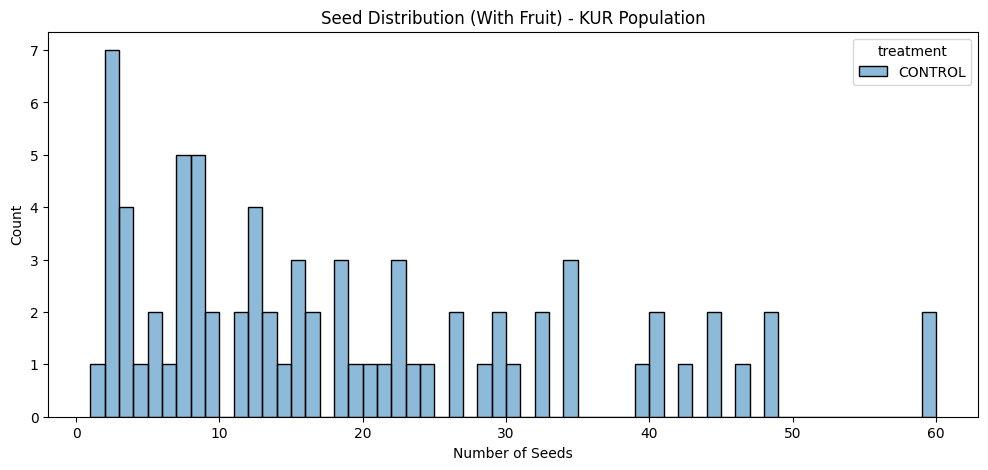

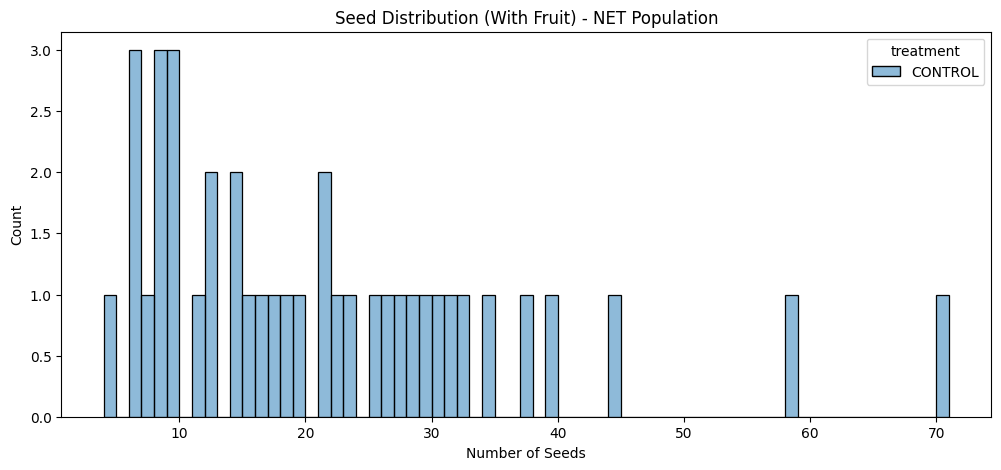

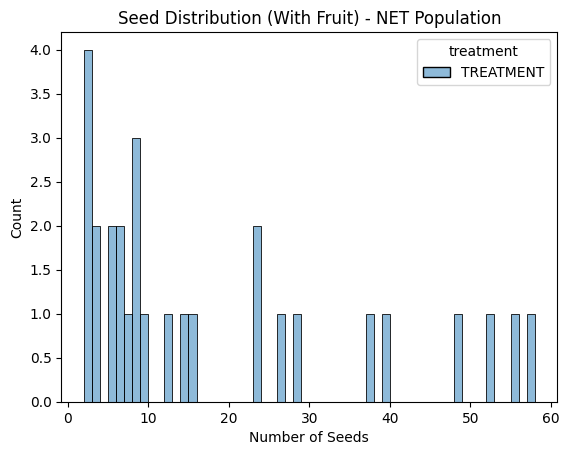

In [ ]:
# Create three separate plots for seeds when fruit=1
plt.figure(figsize=(12, 5))
sns.histplot(data=df[(df['population']=='KUR') & (df['fruit']==1)], 
             x='seed', hue='treatment', multiple="layer", alpha=0.5, binwidth=1)
plt.title('Seed Distribution (With Fruit) - KUR Population')
plt.xlabel('Number of Seeds')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 5))

sns.histplot(data=df[(df['population']=='NET') & (df['fruit']==1) & (df['treatment']=='CONTROL')], 
             x='seed', hue='treatment', multiple="layer", alpha=0.5, binwidth=1)
plt.title('Seed Distribution (With Fruit) - NET Population')
plt.xlabel('Number of Seeds')
plt.ylabel('Count') 
plt.show()

sns.histplot(data=df[(df['population']=='NET') & (df['fruit']==1)& (df['treatment']=='TREATMENT')], 
             x='seed', hue='treatment', multiple="layer", alpha=0.5, binwidth=1)
plt.title('Seed Distribution (With Fruit) - NET Population')
plt.xlabel('Number of Seeds')
plt.ylabel('Count') 
plt.show()

## 2024 - Genotype Based

### Load data

In [ ]:
# Group data by genotype_id and calculate mean values
df_g1 = df.groupby('genotype_id')[['flower_size', 'black_patch', 'tunnel_volume']].agg(['mean', 'std', 'count'])
df_g1.columns = ['_'.join(col).strip() for col in df_g1.columns.values]

# Group data by genotype_id and calculate mean values
df_g2 = df.groupby('genotype_id')[['population', 'treatment']].agg(['first'])
df_g2.columns = [col[0] for col in df_g2.columns.values]

# Concatenate the two grouped dataframes
df_g = pd.concat([df_g1, df_g2], axis=1)


# Flatten column multi-index

# Display the summary
df_g.head()


,flower_size_mean,flower_size_std,flower_size_count,black_patch_mean,black_patch_std,black_patch_count,tunnel_volume_mean,tunnel_volume_std,tunnel_volume_count,population,treatment
genotype_id,,,,,,,,,,,
K135,29.63240,NaN,1,6.5900,NaN,1,3.716060,NaN,1,KUR,CONTROL
K136,45.22400,7.546244,2,8.1345,3.172788,2,4.297860,0.964013,2,KUR,CONTROL
K139,36.64200,NaN,1,7.9030,NaN,1,3.153465,NaN,1,KUR,CONTROL
K140,36.01908,3.339875,5,6.9836,0.809390,5,3.388075,0.807534,5,KUR,CONTROL
K142,51.31620,NaN,1,7.4450,NaN,1,3.611496,NaN,1,KUR,CONTROL


In [ ]:
# Calculate Sum_Fruits, Sum_flowers (total count of flowers), and Sum_seeds per genotype
agg_calculations = df.groupby('genotype_id').agg(
    Sum_Fruits=('fruit', 'sum'),  # Sums 1s from the 'fruit' column (NaNs are treated as 0 by sum)
    Sum_flowers=('genotype_id', 'count'),  # Total number of flowers (rows) for the genotype
    Sum_seeds=('seed', 'sum')    # Sum of 'seed' column (NaNs are treated as 0 by sum)
)

# Calculate Fruitset
agg_calculations['Fruitset'] = agg_calculations['Sum_Fruits'] / agg_calculations['Sum_flowers']

# Calculate Seedset
# Sum_Fruits can be 0, leading to division by zero. We'll replace resulting infinity with 0 or NaN.
# Here, we'll replace with 0, assuming 0 seedset if no fruits.
agg_calculations['Seedset'] = agg_calculations['Sum_seeds'] / agg_calculations['Sum_Fruits']
agg_calculations['Seedset'] = agg_calculations['Seedset'].replace([float('inf'), -float('inf')], float('nan')) # Replace inf with NaN first
agg_calculations['Seedset'] = agg_calculations['Seedset'].fillna(0) # Then fill NaN (0/0 or seeds/0) with 0

# Add Fruitset and Seedset to your df_g DataFrame
# df_g is already indexed by genotype_id, as is agg_calculations
df_g = pd.concat([df_g, agg_calculations[['Fruitset', 'Seedset']]], axis=1)

# Display the summary with the new columns
print("DataFrame df_g with Fruitset and Seedset:")
df_g.head()

DataFrame df_g with Fruitset and Seedset:


,flower_size_mean,flower_size_std,flower_size_count,black_patch_mean,black_patch_std,black_patch_count,tunnel_volume_mean,tunnel_volume_std,tunnel_volume_count,population,treatment,Fruitset,Seedset
genotype_id,,,,,,,,,,,,,
K135,29.63240,NaN,1,6.5900,NaN,1,3.716060,NaN,1,KUR,CONTROL,1.0,8.00
K136,45.22400,7.546244,2,8.1345,3.172788,2,4.297860,0.964013,2,KUR,CONTROL,0.0,0.00
K139,36.64200,NaN,1,7.9030,NaN,1,3.153465,NaN,1,KUR,CONTROL,1.0,19.00
K140,36.01908,3.339875,5,6.9836,0.809390,5,3.388075,0.807534,5,KUR,CONTROL,0.8,29.25
K142,51.31620,NaN,1,7.4450,NaN,1,3.611496,NaN,1,KUR,CONTROL,0.0,0.00


### Quantities

In [ ]:
df_g.value_counts(['population','treatment'])

population  treatment
KUR         CONTROL      46
NET         CONTROL      27
            TREATMENT    21
Name: count, dtype: int64

### Exposure Variables Distributions

In [ ]:
df_g.columns

Index(['flower_size_mean', 'flower_size_std', 'flower_size_count',
       'black_patch_mean', 'black_patch_std', 'black_patch_count',
       'tunnel_volume_mean', 'tunnel_volume_std', 'tunnel_volume_count',
       'population', 'treatment', 'Fruitset', 'Seedset'],
      dtype='object')

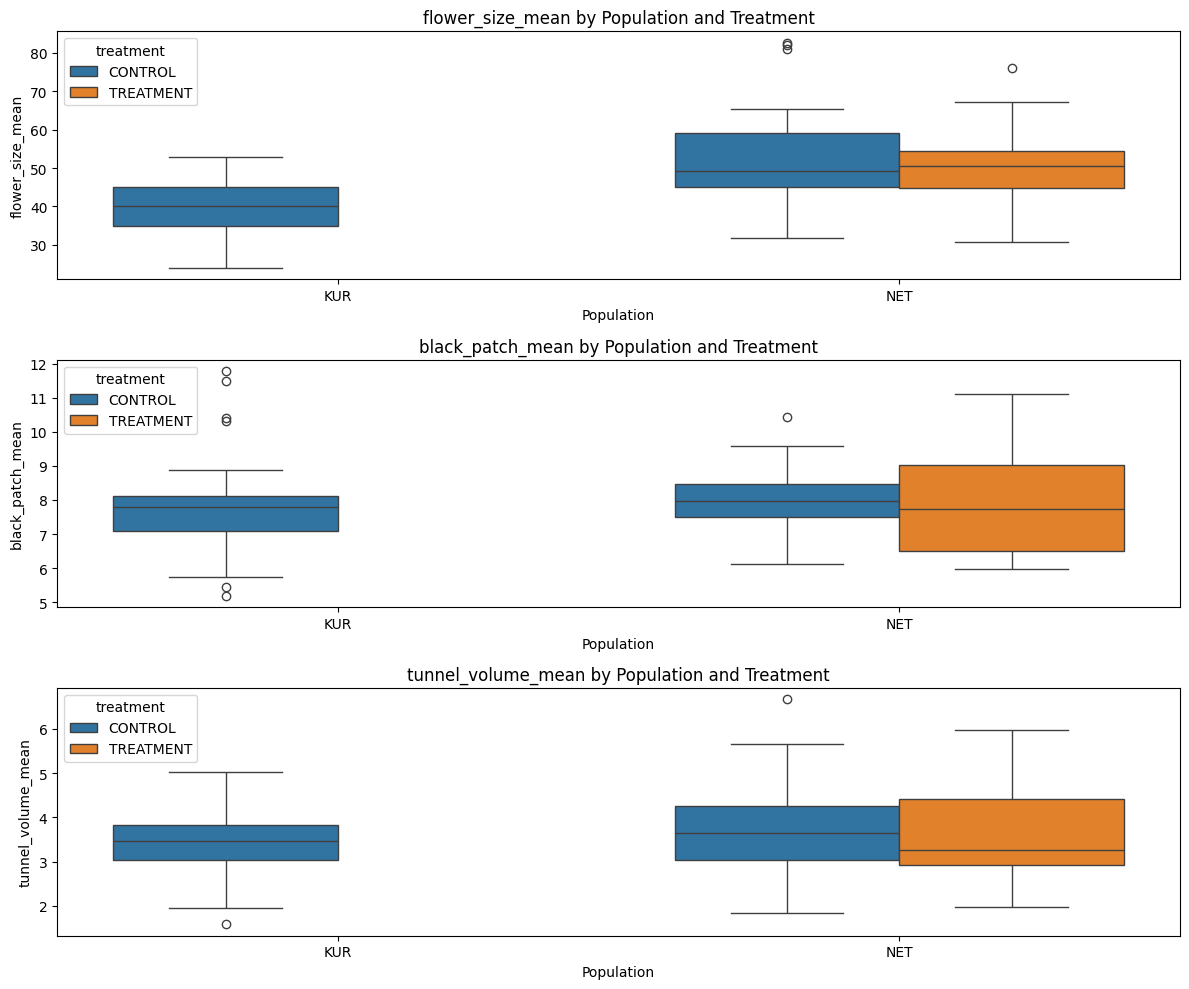

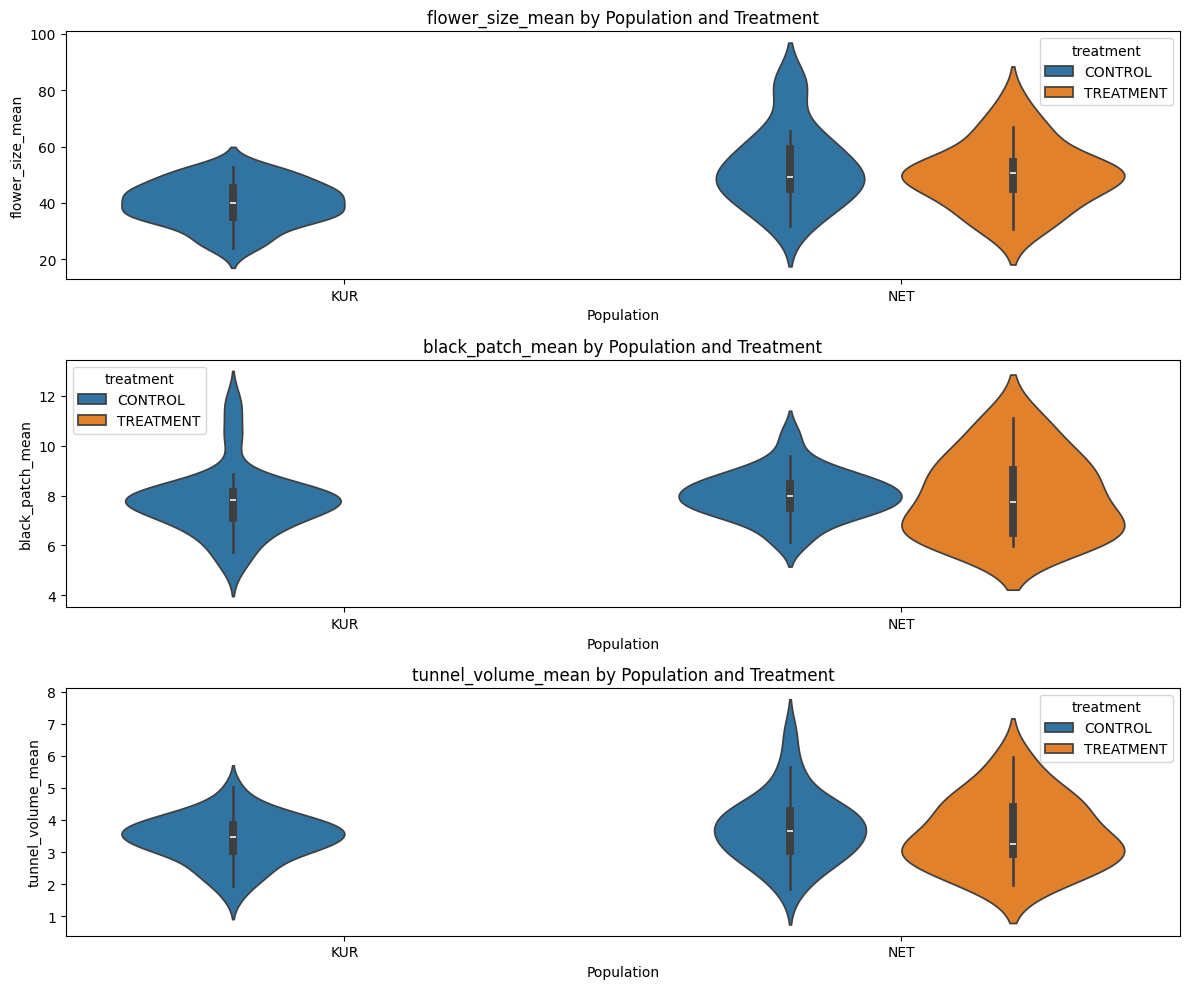

,Variable,Population,Treatment,Count,Mean,Std,Min,Q1,Median,Q3,Max
0,flower_size_mean,KUR,CONTROL,46,39.85,7.63,24.04,34.88,40.02,45.18,52.78
1,flower_size_mean,NET,CONTROL,27,52.79,13.80,31.74,44.94,49.20,59.05,82.65
2,flower_size_mean,NET,TREATMENT,21,49.95,11.54,30.67,44.76,50.53,54.42,75.91
3,black_patch_mean,KUR,CONTROL,46,7.75,1.31,5.18,7.10,7.81,8.12,11.78
4,black_patch_mean,NET,CONTROL,27,8.01,0.94,6.12,7.50,7.97,8.46,10.43
5,black_patch_mean,NET,TREATMENT,21,7.97,1.62,5.98,6.49,7.74,9.02,11.10
6,tunnel_volume_mean,KUR,CONTROL,46,3.40,0.73,1.58,3.03,3.48,3.84,5.03
7,tunnel_volume_mean,NET,CONTROL,27,3.75,1.06,1.83,3.04,3.64,4.27,6.67
8,tunnel_volume_mean,NET,TREATMENT,21,3.57,1.10,1.98,2.94,3.26,4.41,5.98


In [ ]:
variables_to_plot = ['flower_size_mean', 'black_patch_mean', 'tunnel_volume_mean']

plot_population_treatment_distributions(df_g, variables_to_plot)


### Genotype variability

C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topk['genotype_order'] = df_topk['genotype_id'].map(genotype_counts)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

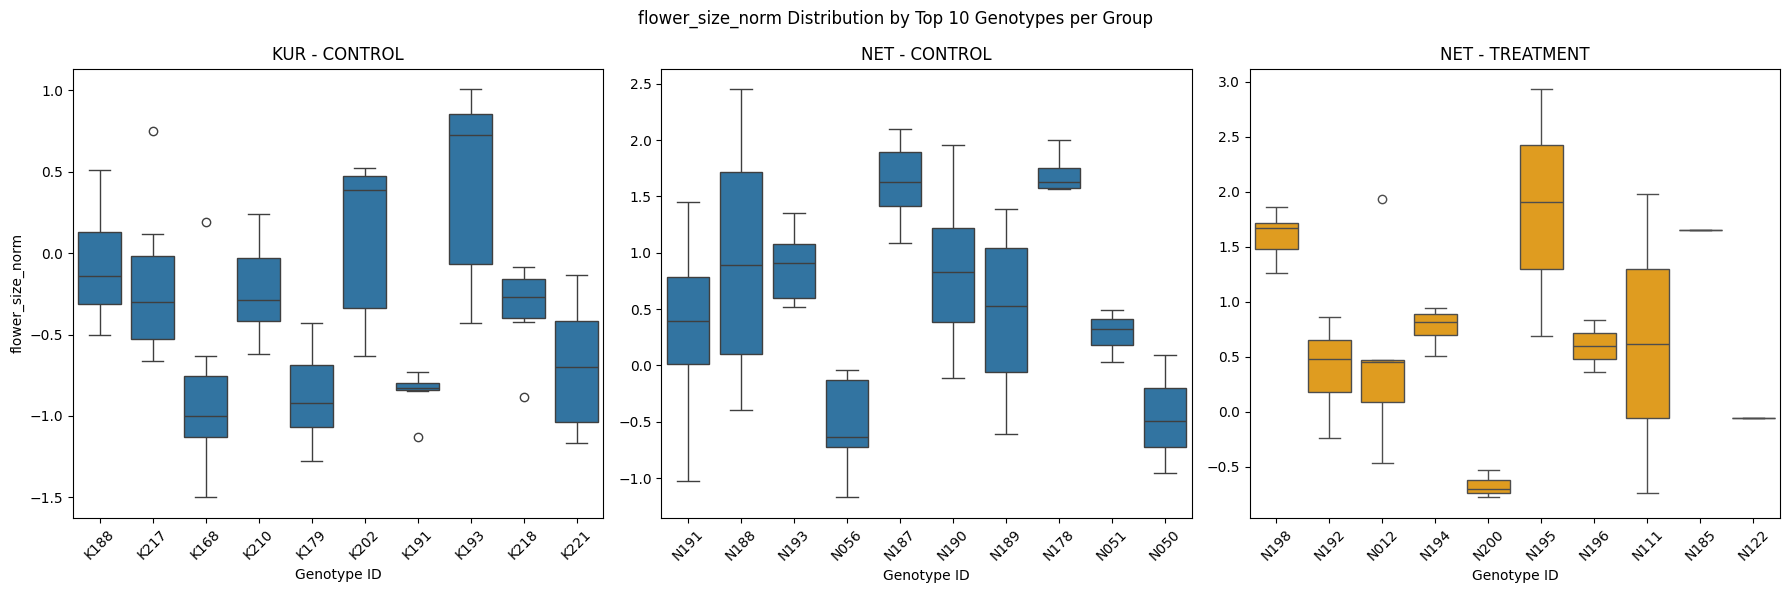

In [ ]:
plot_top_k_genotypes_boxplot(df,'flower_size_norm',k=10)

C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topk['genotype_order'] = df_topk['genotype_id'].map(genotype_counts)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

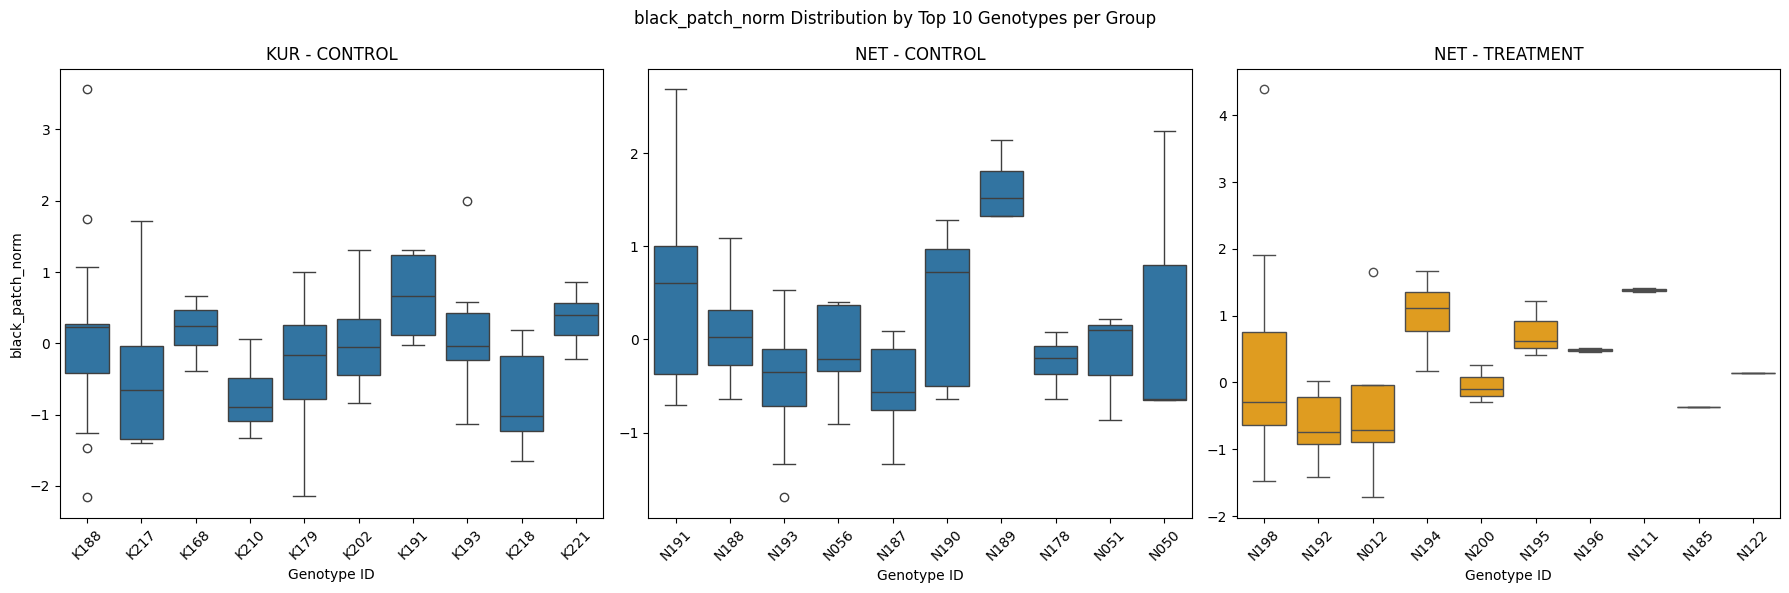

In [ ]:
plot_top_k_genotypes_boxplot(df,'black_patch_norm',k=10)

C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topk['genotype_order'] = df_topk['genotype_id'].map(genotype_counts)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

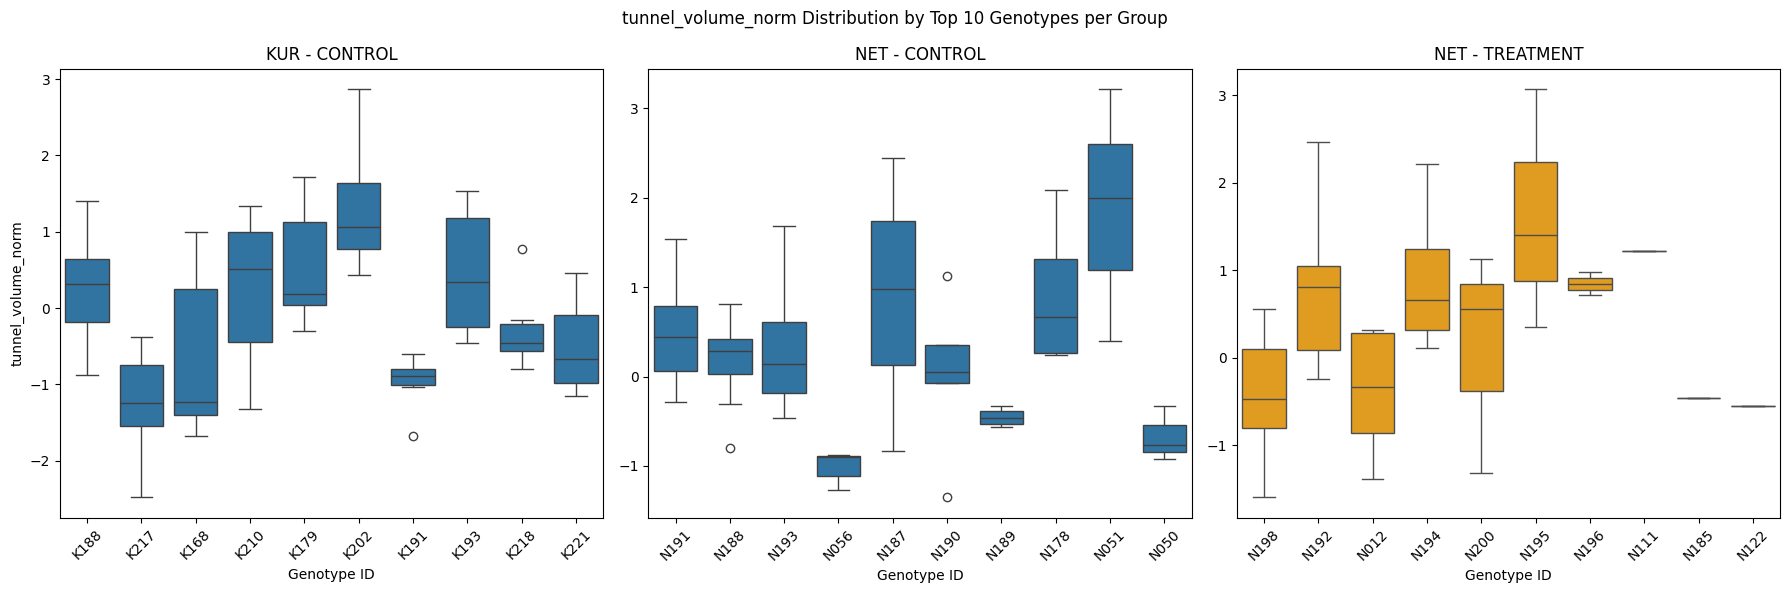

In [ ]:
plot_top_k_genotypes_boxplot(df,'tunnel_volume_norm',k=10)

C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topk['genotype_order'] = df_topk['genotype_id'].map(genotype_counts)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\4204585713.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

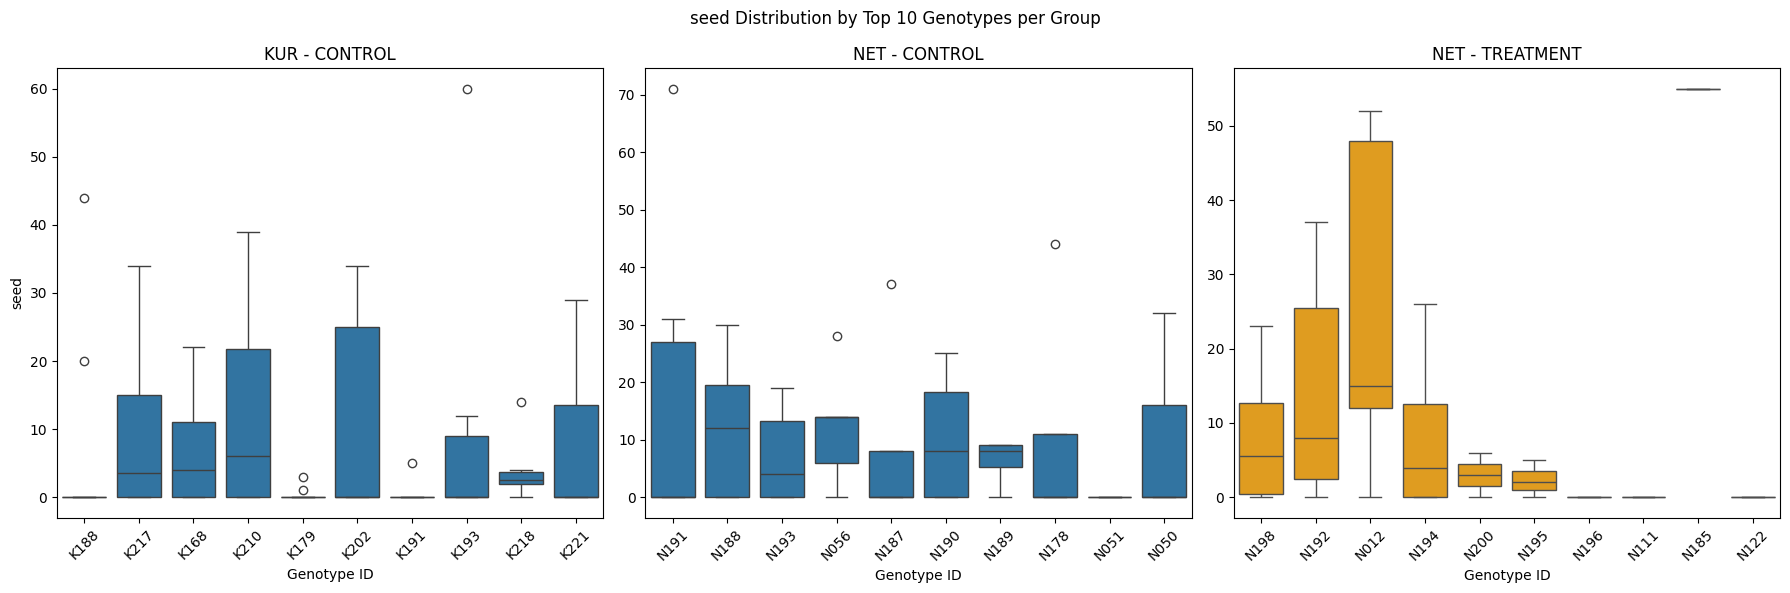

In [ ]:
plot_top_k_genotypes_boxplot(df,'seed',k=10)

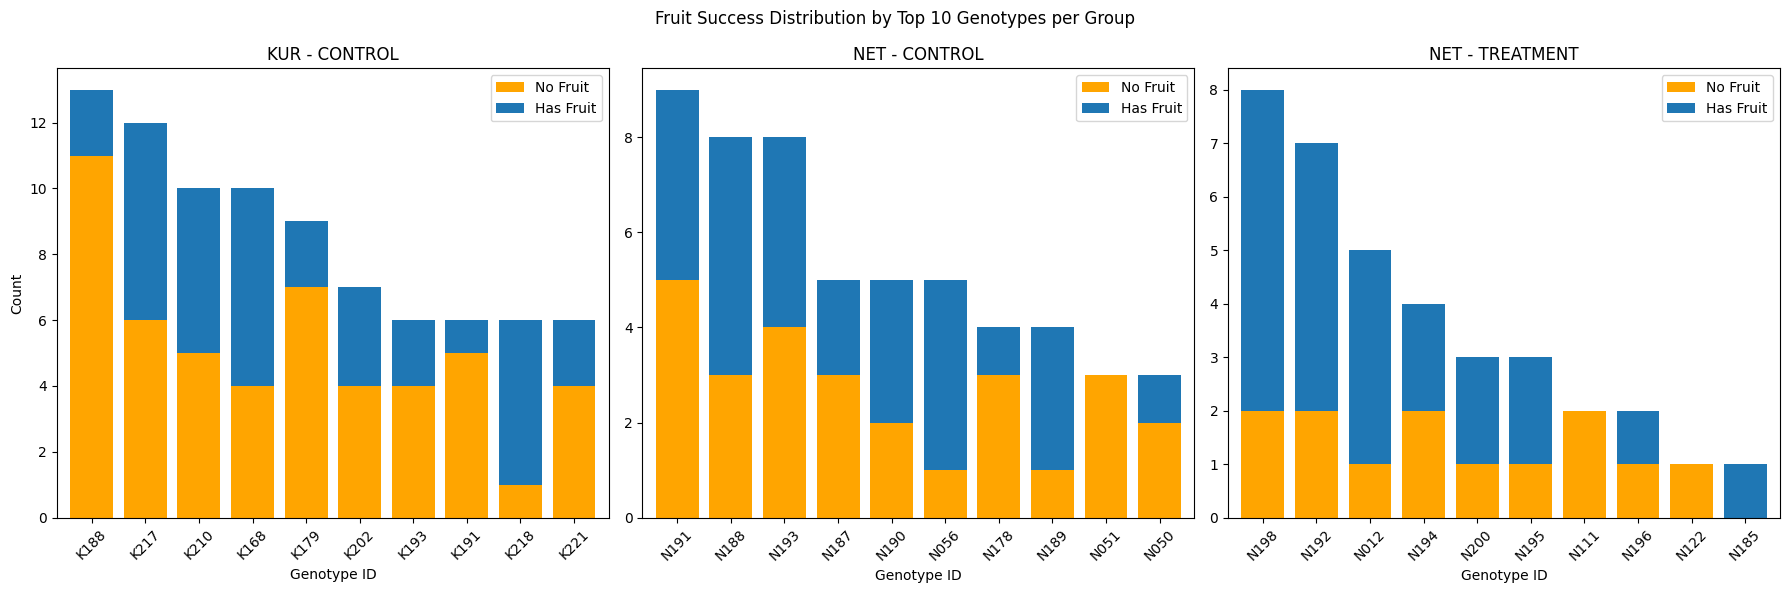

In [ ]:
plot_fruit_success_by_genotype(df,k=10)

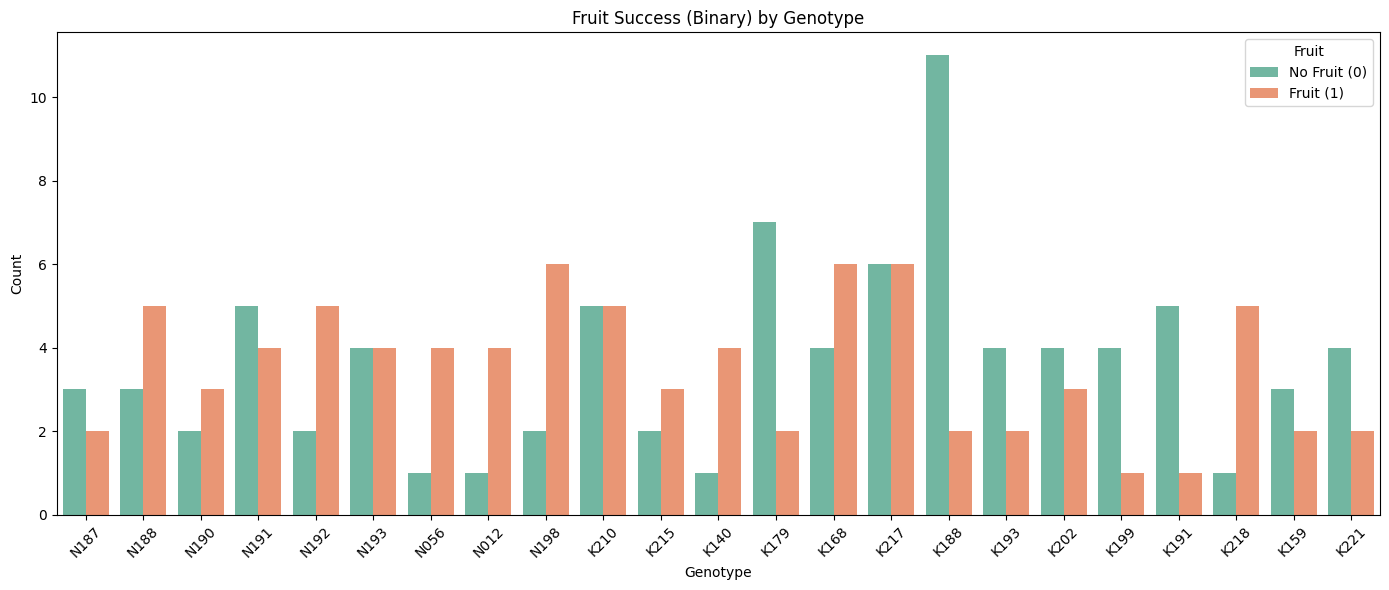

In [ ]:
# Plot fruit success by genotype as a countplot to show the binary outcome
import seaborn as sns

plt.figure(figsize=(14, 6))
# Only keep genotypes with at least 5 observations for clarity
genotype_counts = df['genotype_id'].value_counts()
top_genotypes = genotype_counts[genotype_counts >= 5].index
df_binary = df[df['genotype_id'].isin(top_genotypes)]

sns.countplot(
    data=df_binary,
    x='genotype_id',
    hue='fruit',
    palette='Set2'
)
plt.title('Fruit Success (Binary) by Genotype')
plt.xlabel('Genotype')
plt.ylabel('Count')
plt.legend(title='Fruit', labels=['No Fruit (0)', 'Fruit (1)'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Seed cound distribution assesment

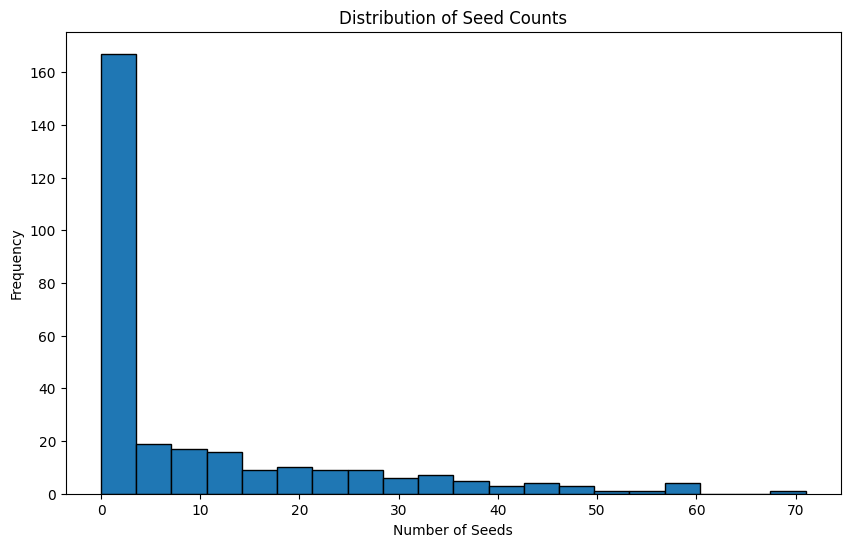

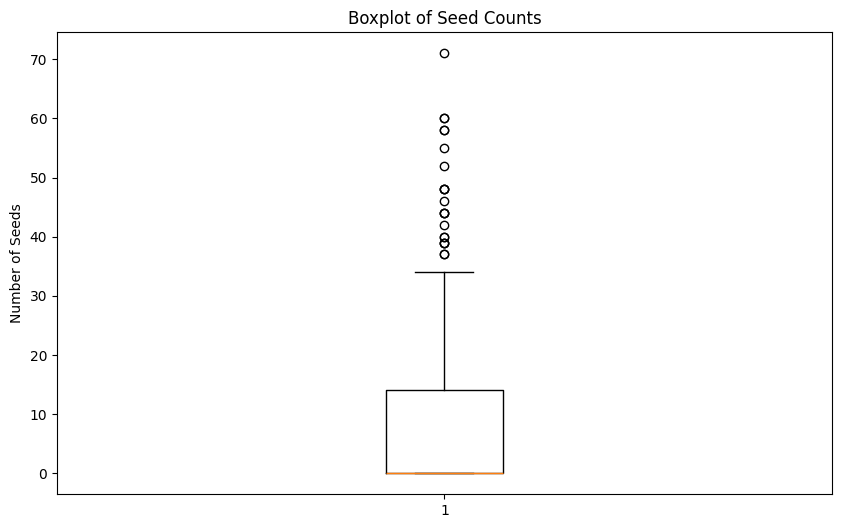


Seed Count Summary Statistics:


,Statistic,Value
0,Mean,9.38
1,Median,0.00
2,Variance,208.91


In [ ]:
# Plot histogram of seed counts
plt.figure(figsize=(10,6))
plt.hist(df['seed'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of Seed Counts')
plt.xlabel('Number of Seeds')
plt.ylabel('Frequency')
plt.show()

# Add boxplot
plt.figure(figsize=(10,6))
plt.boxplot(df['seed'].dropna())
plt.title('Boxplot of Seed Counts')
plt.ylabel('Number of Seeds')
plt.show()

# Calculate summary statistics for seed counts
seed_stats = {
    'Statistic': ['Mean', 'Median', 'Variance'],
    'Value': [
        df['seed'].mean(),
        df['seed'].median(), 
        df['seed'].var()
    ]
}
stats_df = pd.DataFrame(seed_stats)


print("\nSeed Count Summary Statistics:")
display(stats_df.style.format({
    'Value': '{:.2f}'
}))


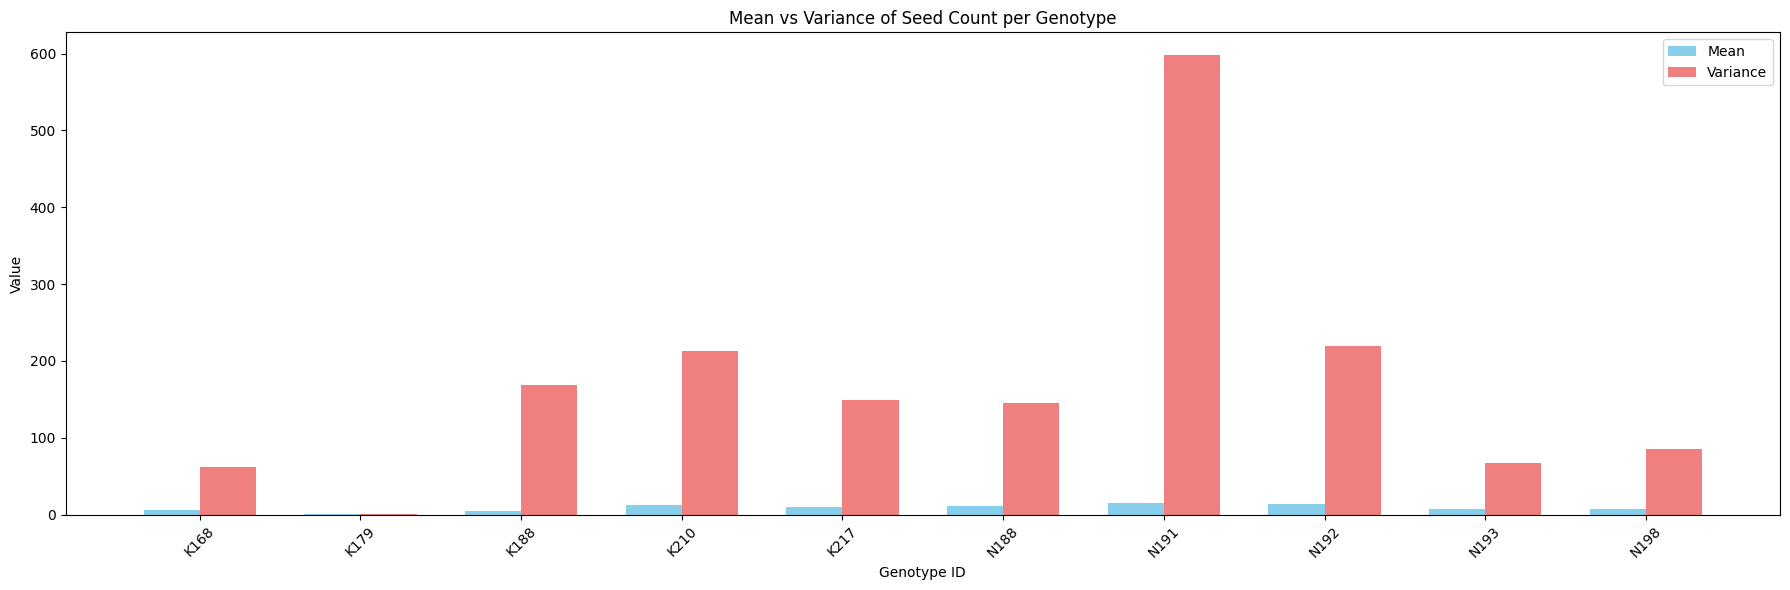


Seed statistics for top 10 genotypes:
             seed_mean  seed_variance
genotype_id                          
K168          6.600000      61.377778
K179          0.444444       1.027778
K188          4.923077     168.410256
K210         12.300000     213.122222
K217          9.416667     148.628788
N188         11.571429     145.285714
N191         14.777778     597.694444
N192         14.428571     218.952381
N193          7.000000      66.571429
N198          8.000000      85.200000


In [ ]:
# Calculate Genotype Sizes and prepare data
genotype_sizes = df.groupby('genotype_id').size().sort_values(ascending=False)
top_10_genotypes = genotype_sizes.head(10)
df_top_10 = df[df['genotype_id'].isin(top_10_genotypes.index)]
seed_stats_top_10 = df_top_10.groupby('genotype_id')['seed'].agg(['mean', 'var'])
seed_stats_top_10.columns = ['seed_mean', 'seed_variance']

# Create figure
plt.figure(figsize=(18, 6))

# Plot mean vs variance comparison
x = range(len(seed_stats_top_10))
width = 0.35
plt.bar([i - width/2 for i in x], seed_stats_top_10['seed_mean'], width, label='Mean', color='skyblue')
plt.bar([i + width/2 for i in x], seed_stats_top_10['seed_variance'], width, label='Variance', color='lightcoral')
plt.xticks(x, seed_stats_top_10.index, rotation=45)
plt.title('Mean vs Variance of Seed Count per Genotype')
plt.xlabel('Genotype ID')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

# Print numerical results
print("\nSeed statistics for top 10 genotypes:")
print(seed_stats_top_10)

# Modeling

## Relative fitness estimation

In [ ]:
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,tunnel_length,entr_length,entr_height,tunnel_volume,black_patch,fruit,seed,flower_size_norm,tunnel_volume_norm,black_patch_norm
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,...,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,3.121125,0.643683,0.220275
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,...,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1.656183,-0.463673,-0.363767
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,...,31.0,16.2,8.9,4.469580,7.652,1.0,39.0,1.969366,0.813816,-0.098406
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,...,28.0,11.8,7.9,2.610160,7.958,0.0,0.0,1.627082,-0.847932,0.091315
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,...,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,1.892756,0.449479,-1.335931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,298,2024-03-13,36,KUR,BLUE,K222,222.3,CONTROL,51.4,46.9,...,24.6,12.2,8.0,2.400960,6.464,NaN,NaN,-1.825749,-1.034892,-0.834969
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,...,32.3,11.0,8.2,2.913460,5.452,0.0,0.0,-0.328245,-0.576875,-1.462411
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,...,22.4,10.9,9.7,2.368352,8.919,1.0,13.0,-2.525761,-1.064033,0.687137
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,...,30.7,13.5,5.8,2.403810,7.456,0.0,0.0,-1.163906,-1.032345,-0.219927


In [ ]:
df = df.dropna()
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,tunnel_length,entr_length,entr_height,tunnel_volume,black_patch,fruit,seed,flower_size_norm,tunnel_volume_norm,black_patch_norm
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,...,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,3.121125,0.643683,0.220275
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,...,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1.656183,-0.463673,-0.363767
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,...,31.0,16.2,8.9,4.469580,7.652,1.0,39.0,1.969366,0.813816,-0.098406
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,...,28.0,11.8,7.9,2.610160,7.958,0.0,0.0,1.627082,-0.847932,0.091315
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,...,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,1.892756,0.449479,-1.335931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,295,2024-03-07,30,KUR,RED,K221,221.4,CONTROL,66.8,54.7,...,31.8,11.9,7.8,2.951676,7.885,0.0,0.0,-0.763172,-0.542722,0.046054
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,...,32.3,11.0,8.2,2.913460,5.452,0.0,0.0,-0.328245,-0.576875,-1.462411
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,...,22.4,10.9,9.7,2.368352,8.919,1.0,13.0,-2.525761,-1.064033,0.687137
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,...,30.7,13.5,5.8,2.403810,7.456,0.0,0.0,-1.163906,-1.032345,-0.219927


In [ ]:
df.columns

Index(['S.No.', 'date', 'day', 'population', 'area', 'genotype_id',
       'Flower_id', 'treatment', 'length_mm', 'width_mm', 'ratio_len_wid',
       'flower_size', 'tunnel_length', 'entr_length', 'entr_height',
       'tunnel_volume', 'black_patch', 'fruit', 'seed', 'flower_size_norm',
       'tunnel_volume_norm', 'black_patch_norm'],
      dtype='object')

In [ ]:
df['abs_fitness_flower'] = df['seed'].fillna(0)

# --- 3. Calculate Relative Fitness ---
# Relative fitness (w) is a flower's absolute fitness divided by the mean
# absolute fitness of its group (population x treatment). This is the key 
# response variable for estimating selection gradients directly.
group_mean_fitness = df.groupby(['population', 'treatment'])['abs_fitness_flower'].transform('mean')

# Avoid division by zero if a group has zero mean fitness
# Add a very small number (epsilon) to the denominator
epsilon = 1e-9 
df['relative_fitness'] = df['abs_fitness_flower'] / (group_mean_fitness + epsilon)

# --- 4. Ensure Correct Data Types ---
# Make sure categorical variables are treated as such.
df['genotype_id'] = df['genotype_id'].astype('category')
df['population'] = df['population'].astype('category')
df['treatment'] = df['treatment'].astype('category')

print("Data preparation complete. Relative fitness calculated.")
print(df[['genotype_id', 'treatment', 'abs_fitness_flower', 'relative_fitness']].head())

Data preparation complete. Relative fitness calculated.
  genotype_id  treatment  abs_fitness_flower  relative_fitness
0        N119    CONTROL                 8.0          0.755448
1        N185  TREATMENT                55.0          4.673913
2        N186    CONTROL                39.0          3.682809
3        N186    CONTROL                 0.0          0.000000
4        N187    CONTROL                 0.0          0.000000


C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\745543997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['abs_fitness_flower'] = df['seed'].fillna(0)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\745543997.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relative_fitness'] = df['abs_fitness_flower'] / (group_mean_fitness + epsilon)
C:\Users\asaf4\AppData\Local\Temp\ipykernel_32016\745543997.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

- Talk with Prittee about treatment in Yavne

In [ ]:
df = df.drop(df[(df['population']=='KUR') & (df['treatment']=='SUPP')].index)
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,entr_height,tunnel_volume,black_patch,fruit,seed,flower_size_norm,tunnel_volume_norm,black_patch_norm,abs_fitness_flower,relative_fitness
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,...,8.9,4.279209,8.166,1.0,8.0,3.121125,0.643683,0.220275,8.0,0.755448
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,...,7.8,3.040128,7.224,1.0,55.0,1.656183,-0.463673,-0.363767,55.0,4.673913
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,...,8.9,4.469580,7.652,1.0,39.0,1.969366,0.813816,-0.098406,39.0,3.682809
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,...,7.9,2.610160,7.958,0.0,0.0,1.627082,-0.847932,0.091315,0.0,0.000000
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,...,7.7,4.061904,5.656,0.0,0.0,1.892756,0.449479,-1.335931,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,295,2024-03-07,30,KUR,RED,K221,221.4,CONTROL,66.8,54.7,...,7.8,2.951676,7.885,0.0,0.0,-0.763172,-0.542722,0.046054,0.0,0.000000
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,...,8.2,2.913460,5.452,0.0,0.0,-0.328245,-0.576875,-1.462411,0.0,0.000000
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,...,9.7,2.368352,8.919,1.0,13.0,-2.525761,-1.064033,0.687137,13.0,1.558866
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,...,5.8,2.403810,7.456,0.0,0.0,-1.163906,-1.032345,-0.219927,0.0,0.000000


In [ ]:
# Rename columns to include units
df = df.rename(columns={
    'Flower_size': 'Flower Size (cm^2)',
    'tunnel_volume_cm': 'Tunnel Volume c(cm^3)', 
    'bp_area': 'Black Patch Area (cm^2)'
})
df

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,entr_height,tunnel_volume,black_patch,fruit,seed,flower_size_norm,tunnel_volume_norm,black_patch_norm,abs_fitness_flower,relative_fitness
0,1,2024-02-07,1,NET,BLUE,N119,119.1,CONTROL,100.6,81.5,...,8.9,4.279209,8.166,1.0,8.0,3.121125,0.643683,0.220275,8.0,0.755448
1,2,2024-02-07,1,NET,BROWN,N185,185.1,TREATMENT,84.0,77.2,...,7.8,3.040128,7.224,1.0,55.0,1.656183,-0.463673,-0.363767,55.0,4.673913
2,3,2024-02-07,1,NET,RED,N186,186.1,CONTROL,94.5,72.5,...,8.9,4.469580,7.652,1.0,39.0,1.969366,0.813816,-0.098406,39.0,3.682809
3,4,2024-02-07,1,NET,RED,N186,186.2,CONTROL,91.5,70.5,...,7.9,2.610160,7.958,0.0,0.0,1.627082,-0.847932,0.091315,0.0,0.000000
4,5,2024-02-07,1,NET,GREEN,N187,187.1,CONTROL,95.1,71.1,...,7.7,4.061904,5.656,0.0,0.0,1.892756,0.449479,-1.335931,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,295,2024-03-07,30,KUR,RED,K221,221.4,CONTROL,66.8,54.7,...,7.8,2.951676,7.885,0.0,0.0,-0.763172,-0.542722,0.046054,0.0,0.000000
298,299,2024-03-13,36,KUR,BLUE,K204,204.2,CONTROL,70.2,59.3,...,8.2,2.913460,5.452,0.0,0.0,-0.328245,-0.576875,-1.462411,0.0,0.000000
299,300,2024-03-13,36,KUR,Brown,K159,159.5,CONTROL,42.9,37.1,...,9.7,2.368352,8.919,1.0,13.0,-2.525761,-1.064033,0.687137,13.0,1.558866
300,301,2024-03-13,36,KUR,RED,K221,221.5,CONTROL,60.9,52.3,...,5.8,2.403810,7.456,0.0,0.0,-1.163906,-1.032345,-0.219927,0.0,0.000000


In [ ]:
group_mean_fitness.value_counts()

abs_fitness_flower
8.339394     165
10.589744     78
11.767442     43
Name: count, dtype: int64

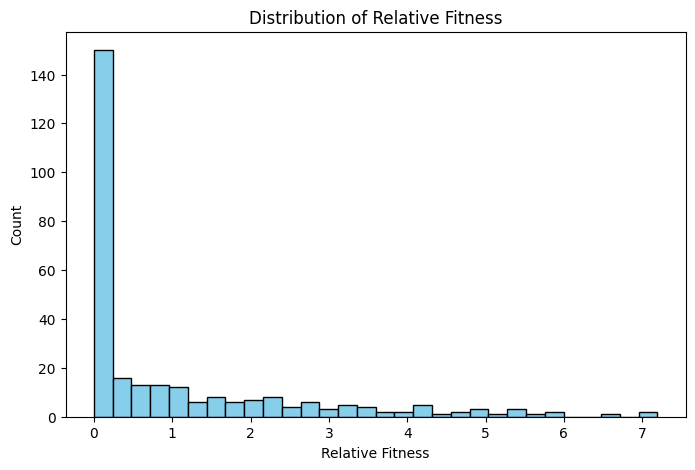

In [ ]:

plt.figure(figsize=(8, 5))
plt.hist(df['relative_fitness'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Relative Fitness')
plt.ylabel('Count')
plt.title('Distribution of Relative Fitness')
plt.show()

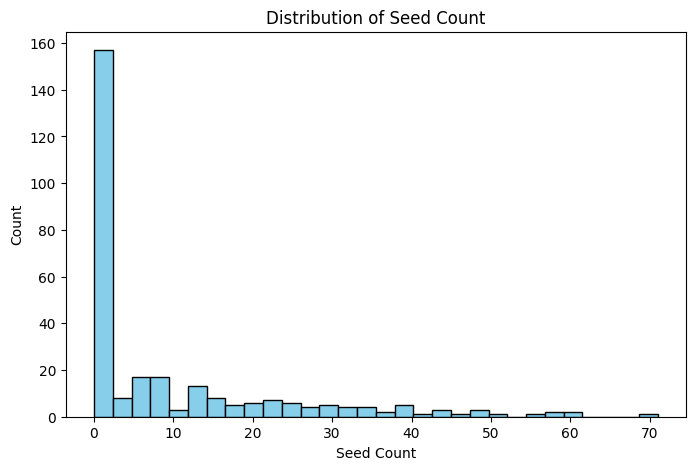

In [ ]:

plt.figure(figsize=(8, 5))
plt.hist(df['seed'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Seed Count')
plt.ylabel('Count')
plt.title('Distribution of Seed Count')
plt.show()

In [ ]:

# Define the model formula
# This model estimates directional selection gradients (β)
lmm_formula = """relative_fitness ~ (flower_size_norm + tunnel_volume_norm + black_patch_norm) * treatment 
                                + population"""

# Fit the Linear Mixed-Effects Model
# The 'groups' argument specifies the random effect structure
lmm_model = smf.mixedlm(formula=lmm_formula, 
                        data=df, 
                        groups=df['genotype_id'])

lmm_results = lmm_model.fit()

In [ ]:
# Print the summary
print("--- LMM Results for Relative Fitness (Selection Gradients) ---")
print(lmm_results.summary())

--- LMM Results for Relative Fitness (Selection Gradients) ---
                       Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        relative_fitness
No. Observations:         286            Method:                    REML            
No. Groups:               93             Scale:                     2.2212          
Min. group size:          1              Log-Likelihood:            -531.5817       
Max. group size:          13             Converged:                 Yes             
Mean group size:          3.1                                                       
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  1.153    0.151  7.615 0.000  0.856  1.450
treatment[T.TREATMENT]    

In [ ]:
quadratic_lmm_formula = """relative_fitness ~ 
                                (flower_size_norm + I(flower_size_norm**2) +
                                 tunnel_volume_norm + I(tunnel_volume_norm**2) +
                                 black_patch_norm + I(black_patch_norm**2)) * treatment +
                                 population"""

# Fit the Linear Mixed-Effects Model with quadratic terms
quadratic_lmm_model = smf.mixedlm(formula=quadratic_lmm_formula, 
                                  data=df, 
                                  groups=df['genotype_id'])

quadratic_lmm_results = quadratic_lmm_model.fit()

# Print the full summary
print("--- LMM Results with Quadratic Terms (Stabilizing/Disruptive Selection) ---")
print(quadratic_lmm_results.summary())

--- LMM Results with Quadratic Terms (Stabilizing/Disruptive Selection) ---
                           Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           relative_fitness
No. Observations:           286               Method:                       REML            
No. Groups:                 93                Scale:                        2.2070          
Min. group size:            1                 Log-Likelihood:               -536.5465       
Max. group size:            13                Converged:                    Yes             
Mean group size:            3.1                                                             
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept             

## Two - Part Modeling

In [ ]:
# --- The Corrected Import Statements ---
from pymer4.models import glmer
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri


In [ ]:
import os
import pandas as pd
import numpy as np # Import numpy

# Set the R_HOME environment variable for robustness
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.1'

# Import the necessary rpy2 tools
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import conversion as rpy2_conversion
import rpy2.robjects as ro

print("Successfully imported libraries!")

Successfully imported libraries!


In [ ]:
# --- This context manager is ONLY for running the model ---
with rpy2_conversion.localconverter(ro.default_converter + pandas2ri.converter):
    lme4 = importr('lme4')
    base = importr('base')
    
    # Run the first model
    fruit_hurdle_formula = "fruit ~ flower_size_norm * treatment + tunnel_volume_norm * treatment + black_patch_norm * treatment + population + (1|genotype_id)"
    fruit_hurdle_model_r = lme4.glmer(ro.Formula(fruit_hurdle_formula), data=df, family="binomial")
    
    # Run the second model
    df_fruitful = df[df['fruit'] == 1].copy()
    seed_count_formula = "seed ~ flower_size_norm * treatment + tunnel_volume_norm * treatment + black_patch_norm * treatment + population + (1|genotype_id)"
    seed_count_model_r = lme4.glmer(ro.Formula(seed_count_formula), data=df_fruitful, family="poisson")
    
    # Get the R summary objects
    summary_fruit = base.summary(fruit_hurdle_model_r)
    summary_seed = base.summary(seed_count_model_r)




## Fresh

In [ ]:
import polars as pl
df_r = pl.DataFrame(df)
df_r

S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,flower_size,tunnel_length,entr_length,entr_height,tunnel_volume,black_patch,fruit,seed,flower_size_norm,tunnel_volume_norm,black_patch_norm,abs_fitness_flower,relative_fitness
i64,str,i64,cat,str,cat,f64,cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2024-02-07""",1,"""NET""","""BLUE""","""N119""",119.1,"""CONTROL""",100.6,81.5,1.234356,81.989,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,3.121125,0.643683,0.220275,8.0,0.755448
2,"""2024-02-07""",1,"""NET""","""BROWN""","""N185""",185.1,"""TREATMENT""",84.0,77.2,1.088083,64.848,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1.656183,-0.463673,-0.363767,55.0,4.673913
3,"""2024-02-07""",1,"""NET""","""RED""","""N186""",186.1,"""CONTROL""",94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.46958,7.652,1.0,39.0,1.969366,0.813816,-0.098406,39.0,3.682809
4,"""2024-02-07""",1,"""NET""","""RED""","""N186""",186.2,"""CONTROL""",91.5,70.5,1.297872,64.5075,28.0,11.8,7.9,2.61016,7.958,0.0,0.0,1.627082,-0.847932,0.091315,0.0,0.0
5,"""2024-02-07""",1,"""NET""","""GREEN""","""N187""",187.1,"""CONTROL""",95.1,71.1,1.337553,67.6161,31.4,16.8,7.7,4.061904,5.656,0.0,0.0,1.892756,0.449479,-1.335931,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
295,"""2024-03-07""",30,"""KUR""","""RED""","""K221""",221.4,"""CONTROL""",66.8,54.7,1.221207,36.5396,31.8,11.9,7.8,2.951676,7.885,0.0,0.0,-0.763172,-0.542722,0.046054,0.0,0.0
299,"""2024-03-13""",36,"""KUR""","""BLUE""","""K204""",204.2,"""CONTROL""",70.2,59.3,1.183811,41.6286,32.3,11.0,8.2,2.91346,5.452,0.0,0.0,-0.328245,-0.576875,-1.462411,0.0,0.0
300,"""2024-03-13""",36,"""KUR""","""Brown""","""K159""",159.5,"""CONTROL""",42.9,37.1,1.156334,15.9159,22.4,10.9,9.7,2.368352,8.919,1.0,13.0,-2.525761,-1.064033,0.687137,13.0,1.558866


In [ ]:
df_fruitful_r = pl.DataFrame(df_fruitful)

In [ ]:
formula = "fruit ~ flower_size_norm * treatment + tunnel_volume_norm * treatment + black_patch_norm * treatment + population + (1|genotype_id)"
log_regress = glmer(formula, data=df_r, family='binomial')
log_regress.fit()

In [ ]:
log_regress.summary()

GT(_tbl_data=shape: (12, 10)
┌────────────────┬────────────────┬───────────┬───────────┬───┬───────────┬──────┬─────────┬───────┐
│ rfx            ┆ param          ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat    ┆ df   ┆ p_value ┆ stars │
│ ---            ┆ ---            ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---  ┆ ---     ┆ ---   │
│ str            ┆ str            ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64  ┆ str     ┆ str   │
╞════════════════╪════════════════╪═══════════╪═══════════╪═══╪═══════════╪══════╪═════════╪═══════╡
│ genotype_id-sd ┆ (Intercept)    ┆ 0.243289  ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ Fixed Effects: ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ (Intercept)    ┆ -0.076497 ┆ -0.443996 ┆ … ┆ -0.407979 ┆ inf  ┆ 0.6833  ┆       │
│ null           ┆ flower_size_no ┆ 0.322957  ┆ -0.048353 ┆ … ┆ 1.704731  ┆ inf  ┆ 0.08824 ┆ .     │
│                ┆ rm             ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ …              ┆ …              ┆ …         ┆ …         ┆ … ┆ …         ┆ …    ┆ …       ┆ …     │
│ null           ┆ black_patch_no ┆ 0.020522  ┆ -0.256112 ┆ … ┆ 0.145401  ┆ inf  ┆ 0.8844  ┆       │
│                ┆ rm             ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ populationNET  ┆ -0.099151 ┆ -0.795982 ┆ … ┆ -0.278879 ┆ inf  ┆ 0.7803  ┆       │
│ null           ┆ flower_size_no ┆ -0.275444 ┆ -1.061632 ┆ … ┆ -0.686682 ┆ inf  ┆ 0.4923  ┆       │
│                ┆ rm:treatmentTR ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ EA…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ treatmentTREAT ┆ -0.199457 ┆ -0.885949 ┆ … ┆ -0.569457 ┆ inf  ┆ 0.569   ┆       │
│                ┆ MENT:tunnel_vo ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ lu…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ treatmentTREAT ┆ 0.116266  ┆ -0.599101 ┆ … ┆ 0.318545  ┆ inf  ┆ 0.7501  ┆       │
│                ┆ MENT:black_pat ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ ch…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
└────────────────┴────────────────┴───────────┴───────────┴───┴───────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x0000020E7FC38EC0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000020E83DB4A10>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(fruit~flower_size_norm*trea

In [ ]:
formula_model_2 = "fruit ~ (flower_size_norm + tunnel_volume_norm + black_patch_norm + I(flower_size_norm^2) + I(tunnel_volume_norm^2) + I(black_patch_norm^2)) * treatment + population + (1|genotype_id)"
log_regress = glmer(formula_model_2, data=df_r, family='binomial')
log_regress.fit()

In [ ]:
log_regress.summary()

GT(_tbl_data=shape: (18, 10)
┌────────────────┬────────────────┬───────────┬───────────┬───┬───────────┬──────┬─────────┬───────┐
│ rfx            ┆ param          ┆ estimate  ┆ conf_low  ┆ … ┆ z_stat    ┆ df   ┆ p_value ┆ stars │
│ ---            ┆ ---            ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---  ┆ ---     ┆ ---   │
│ str            ┆ str            ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64  ┆ str     ┆ str   │
╞════════════════╪════════════════╪═══════════╪═══════════╪═══╪═══════════╪══════╪═════════╪═══════╡
│ genotype_id-sd ┆ (Intercept)    ┆ 0.295813  ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ Fixed Effects: ┆ null           ┆ null      ┆ null      ┆ … ┆ null      ┆ null ┆ null    ┆ null  │
│ null           ┆ (Intercept)    ┆ -0.078462 ┆ -0.557125 ┆ … ┆ -0.321277 ┆ inf  ┆ 0.748   ┆       │
│ null           ┆ flower_size_no ┆ 0.253103  ┆ -0.144414 ┆ … ┆ 1.24793   ┆ inf  ┆ 0.2121  ┆       │
│                ┆ rm             ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ …              ┆ …              ┆ …         ┆ …         ┆ … ┆ …         ┆ …    ┆ …       ┆ …     │
│ null           ┆ tunnel_volume_ ┆ -0.545186 ┆ -1.616687 ┆ … ┆ -0.997242 ┆ inf  ┆ 0.3186  ┆       │
│                ┆ norm:treatment ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ TR…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ black_patch_no ┆ -0.065745 ┆ -0.956614 ┆ … ┆ -0.144642 ┆ inf  ┆ 0.885   ┆       │
│                ┆ rm:treatmentTR ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ EA…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ I(flower_size_ ┆ 0.677552  ┆ -0.287233 ┆ … ┆ 1.376449  ┆ inf  ┆ 0.1687  ┆       │
│                ┆ norm^2):treatm ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ en…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ I(tunnel_volum ┆ 0.499366  ┆ -0.108197 ┆ … ┆ 1.610926  ┆ inf  ┆ 0.1072  ┆       │
│                ┆ e_norm^2):trea ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ tm…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│ null           ┆ I(black_patch_ ┆ 0.801988  ┆ -0.086732 ┆ … ┆ 1.768687  ┆ inf  ┆ 0.07695 ┆ .     │
│                ┆ norm^2):treatm ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
│                ┆ en…            ┆           ┆           ┆   ┆           ┆      ┆         ┆       │
└────────────────┴────────────────┴───────────┴───────────┴───┴───────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x0000020E83DD73B0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_al

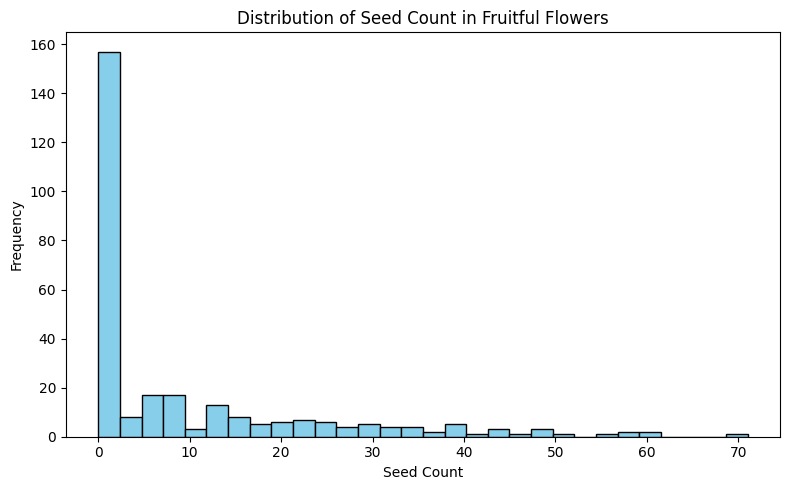

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df['seed'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Seed Count')
plt.ylabel('Frequency')
plt.title('Distribution of Seed Count in Fruitful Flowers')
plt.tight_layout()
plt.show()

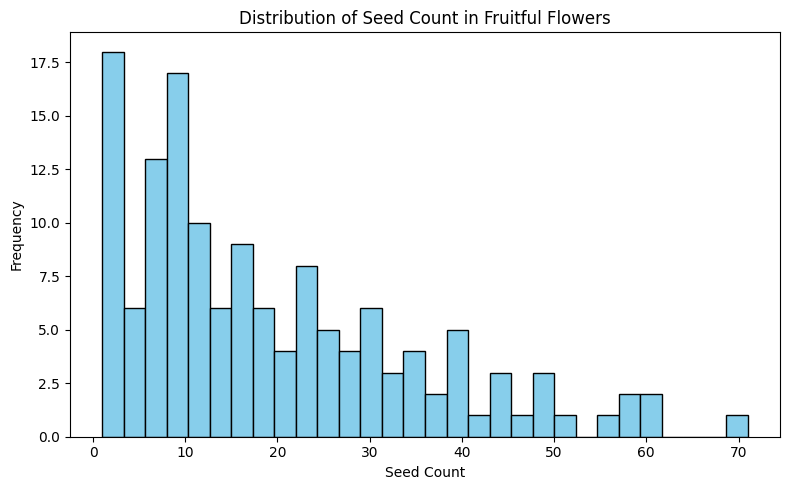

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_fruitful['seed'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Seed Count')
plt.ylabel('Frequency')
plt.title('Distribution of Seed Count in Fruitful Flowers')
plt.tight_layout()
plt.show()

In [ ]:
### Statistical Test: Poisson vs Negative Binomial for Seed Distribution

# First, let's get the seed data for flowers that produced fruit
df_fruitful = df[df['fruit'] == 1].copy()
seed_data = df_fruitful['seed'].dropna()

print(f"Number of fruitful flowers with seed data: {len(seed_data)}")
print(f"Mean seed count: {seed_data.mean():.3f}")
print(f"Variance of seed count: {seed_data.var():.3f}")
print(f"Variance-to-mean ratio: {seed_data.var()/seed_data.mean():.3f}")
print(f"Standard deviation: {seed_data.std():.3f}")

# Variance-to-mean ratio interpretation:
# - If ≈ 1: suggests Poisson distribution (equidispersion)
# - If > 1: suggests overdispersion (negative binomial may be better)
# - If < 1: suggests underdispersion (rare, but possible)

print("\n" + "="*50)
print("VARIANCE-TO-MEAN RATIO INTERPRETATION:")
if seed_data.var()/seed_data.mean() > 1.5:
    print("Strong evidence of OVERDISPERSION - Negative Binomial likely better")
elif seed_data.var()/seed_data.mean() > 1.1:
    print("Moderate overdispersion - Negative Binomial may be better")
elif seed_data.var()/seed_data.mean() < 0.9:
    print("Underdispersion detected - Neither Poisson nor NB may be ideal")
else:
    print("Approximately equidispersed - Poisson may be appropriate")
print("="*50)


Number of fruitful flowers with seed data: 141
Mean seed count: 19.206
Variance of seed count: 240.536
Variance-to-mean ratio: 12.524
Standard deviation: 15.509

VARIANCE-TO-MEAN RATIO INTERPRETATION:
Strong evidence of OVERDISPERSION - Negative Binomial likely better


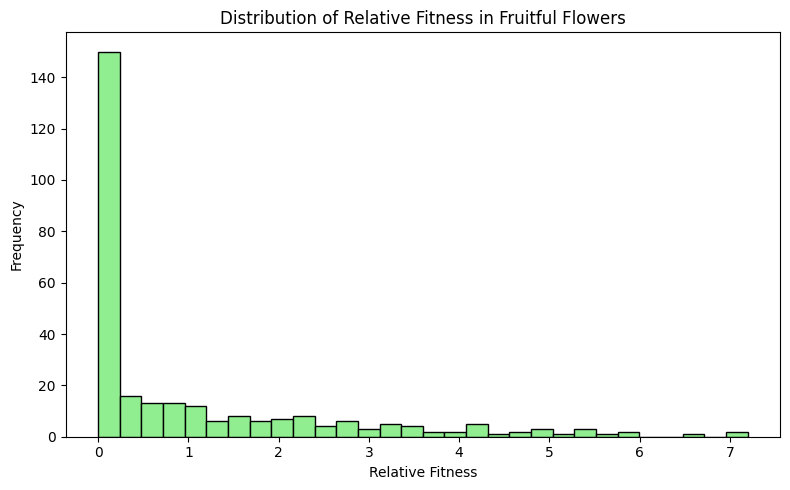

In [ ]:
relative_fitness = df['relative_fitness']

plt.figure(figsize=(8, 5))
plt.hist(relative_fitness, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Relative Fitness')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Fitness in Fruitful Flowers')
plt.tight_layout()
plt.show()

In [ ]:
print("2. TESTING FOR GAMMA DISTRIBUTION With Zero Inflation")
print("="*40)

relative_fitness = df['relative_fitness']

# Fit a gamma distribution to the seed data
# The gamma distribution in scipy is parameterized as: gamma(a, loc, scale)
# We'll use the method of moments (fit) to estimate parameters
gamma_shape, gamma_loc, gamma_scale = stats.gamma.fit(relative_fitness, floc=0)  # force loc=0 for count data

print(f"Fitted gamma parameters: shape={gamma_shape:.3f}, loc={gamma_loc:.3f}, scale={gamma_scale:.3f}")

# Kolmogorov-Smirnov test for goodness-of-fit
ks_stat, ks_p = stats.kstest(relative_fitness, 'gamma', args=(gamma_shape, gamma_loc, gamma_scale))
print(f"Kolmogorov-Smirnov statistic: {ks_stat:.4f}")
print(f"p-value: {ks_p:.4f}")

if ks_p > 0.05:
    print("Fail to reject null hypothesis: Data could plausibly come from a gamma distribution.")
else:
    print("Reject null hypothesis: Data does not follow a gamma distribution.")

# Plot histogram and fitted gamma PDF for visual assessment
plt.figure(figsize=(8, 5))
count, bins, ignored = plt.hist(relative_fitness, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Observed')
x = np.linspace(relative_fitness.min(), relative_fitness.max(), 200)
plt.plot(x, stats.gamma.pdf(x, gamma_shape, gamma_loc, gamma_scale), 'r-', lw=2, label='Fitted Gamma PDF')
plt.xlabel('Relative Fitness')
plt.ylabel('Density')
plt.title('Gamma Fit to Relative Fitness Distribution')
plt.legend()
plt.tight_layout()
plt.show()


2. TESTING FOR GAMMA DISTRIBUTION With Zero Inflation


FitDataError: Invalid values in `data`.  Maximum likelihood estimation with 'gamma' requires that 0 < (x - loc)/scale  < inf for each x in `data`.

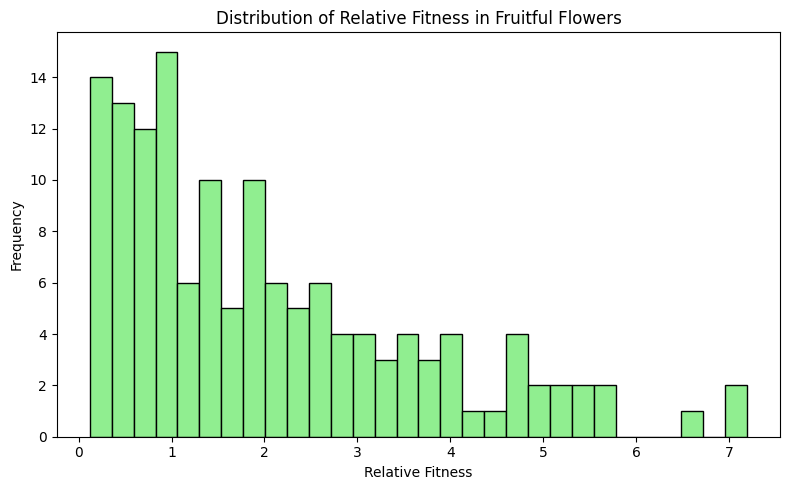

In [ ]:
relative_fitness = df_fruitful['relative_fitness']
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(relative_fitness, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Relative Fitness')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Fitness in Fruitful Flowers')
plt.tight_layout()
plt.show()


2. TESTING FOR GAMMA DISTRIBUTION without Zero Inflation
Fitted gamma parameters: shape=1.417, loc=0.000, scale=1.431
Kolmogorov-Smirnov statistic: 0.0614
p-value: 0.6389
Fail to reject null hypothesis: Data could plausibly come from a gamma distribution.


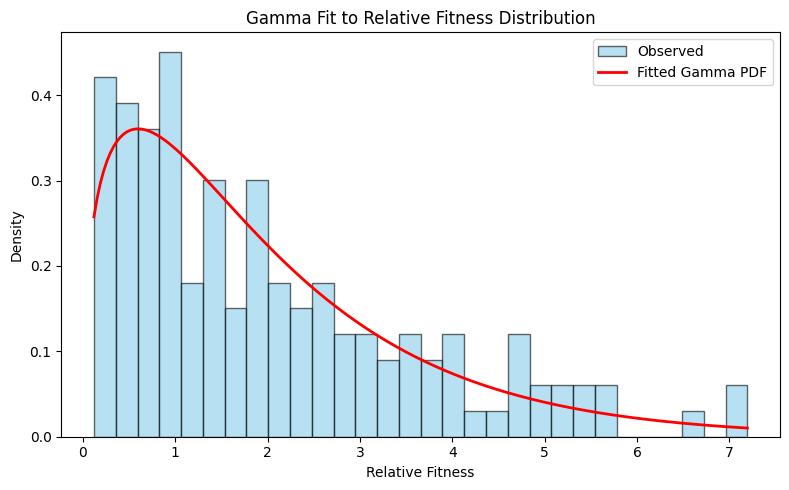

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

print("2. TESTING FOR GAMMA DISTRIBUTION without Zero Inflation")
print("="*40)

# Fit a gamma distribution to the seed data
# The gamma distribution in scipy is parameterized as: gamma(a, loc, scale)
# We'll use the method of moments (fit) to estimate parameters
gamma_shape, gamma_loc, gamma_scale = stats.gamma.fit(relative_fitness, floc=0)  # force loc=0 for count data

print(f"Fitted gamma parameters: shape={gamma_shape:.3f}, loc={gamma_loc:.3f}, scale={gamma_scale:.3f}")

# Kolmogorov-Smirnov test for goodness-of-fit
ks_stat, ks_p = stats.kstest(relative_fitness, 'gamma', args=(gamma_shape, gamma_loc, gamma_scale))
print(f"Kolmogorov-Smirnov statistic: {ks_stat:.4f}")
print(f"p-value: {ks_p:.4f}")

if ks_p > 0.05:
    print("Fail to reject null hypothesis: Data could plausibly come from a gamma distribution.")
else:
    print("Reject null hypothesis: Data does not follow a gamma distribution.")

# Plot histogram and fitted gamma PDF for visual assessment
plt.figure(figsize=(8, 5))
count, bins, ignored = plt.hist(relative_fitness, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Observed')
x = np.linspace(relative_fitness.min(), relative_fitness.max(), 200)
plt.plot(x, stats.gamma.pdf(x, gamma_shape, gamma_loc, gamma_scale), 'r-', lw=2, label='Fitted Gamma PDF')
plt.xlabel('Relative Fitness')
plt.ylabel('Density')
plt.title('Gamma Fit to Relative Fitness Distribution')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
df_fruitful_r

S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,ratio_len_wid,flower_size,tunnel_length,entr_length,entr_height,tunnel_volume,black_patch,fruit,seed,flower_size_norm,tunnel_volume_norm,black_patch_norm,abs_fitness_flower,relative_fitness
i64,str,i64,cat,str,cat,f64,cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,"""2024-02-07""",1,"""NET""","""BLUE""","""N119""",119.1,"""CONTROL""",100.6,81.5,1.234356,81.989,34.1,14.1,8.9,4.279209,8.166,1.0,8.0,3.121125,0.643683,0.220275,8.0,0.755448
2,"""2024-02-07""",1,"""NET""","""BROWN""","""N185""",185.1,"""TREATMENT""",84.0,77.2,1.088083,64.848,33.6,11.6,7.8,3.040128,7.224,1.0,55.0,1.656183,-0.463673,-0.363767,55.0,4.673913
3,"""2024-02-07""",1,"""NET""","""RED""","""N186""",186.1,"""CONTROL""",94.5,72.5,1.303448,68.5125,31.0,16.2,8.9,4.46958,7.652,1.0,39.0,1.969366,0.813816,-0.098406,39.0,3.682809
7,"""2024-02-07""",1,"""NET""","""GREEN""","""N188""",188.2,"""CONTROL""",74.1,71.4,1.037815,52.9074,31.5,14.6,5.8,2.66742,9.572,1.0,21.0,0.635689,-0.796759,1.091998,21.0,1.983051
8,"""2024-02-07""",1,"""NET""","""GREEN""","""N188""",188.3,"""CONTROL""",78.7,74.8,1.052139,58.8676,30.7,13.5,9.3,3.854385,7.501,1.0,30.0,1.145073,0.264021,-0.192027,30.0,2.83293
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
288,"""2024-03-07""",30,"""KUR""","""BLUE""","""K219""",219.2,"""CONTROL""",72.9,61.2,1.191176,44.6148,32.1,12.8,8.4,3.451392,11.838,1.0,46.0,-0.073032,-0.09613,2.496924,46.0,5.515988
290,"""2024-03-07""",30,"""KUR""","""BLUE""","""K220""",220.2,"""CONTROL""",60.3,50.8,1.187008,30.6324,27.3,13.6,9.1,3.378648,8.008,1.0,18.0,-1.268027,-0.161141,0.122315,18.0,2.15843
292,"""2024-03-07""",30,"""KUR""","""RED""","""K221""",221.1,"""CONTROL""",68.6,64.0,1.071875,43.904,34.7,14.0,8.4,4.08072,9.187,1.0,29.0,-0.13378,0.466295,0.853297,29.0,3.477471


In [ ]:
df_fruitful[df_fruitful['relative_fitness'].isna()]

,S.No.,date,day,population,area,genotype_id,Flower_id,treatment,length_mm,width_mm,...,entr_height,tunnel_volume,black_patch,fruit,seed,flower_size_norm,tunnel_volume_norm,black_patch_norm,abs_fitness_flower,relative_fitness


In [ ]:
formula_model_1 = "relative_fitness ~ (flower_size_norm + tunnel_volume_norm + black_patch_norm + flower_size_norm:tunnel_volume_norm + flower_size_norm:black_patch_norm + tunnel_volume_norm:black_patch_norm) * treatment + population + (1|genotype_id)"
formula= "relative_fitness ~ flower_size_norm * treatment + tunnel_volume_norm * treatment + black_patch_norm * treatment + population + (1|genotype_id)"

log_regress = glmer(formula, data=df_fruitful_r, family='Gamma')
log_regress.fit()

In [ ]:
log_regress.summary()

GT(_tbl_data=shape: (13, 10)
┌────────────────┬──────────────────┬──────────┬───────────┬───┬──────────┬──────┬─────────┬───────┐
│ rfx            ┆ param            ┆ estimate ┆ conf_low  ┆ … ┆ z_stat   ┆ df   ┆ p_value ┆ stars │
│ ---            ┆ ---              ┆ ---      ┆ ---       ┆   ┆ ---      ┆ ---  ┆ ---     ┆ ---   │
│ str            ┆ str              ┆ f64      ┆ f64       ┆   ┆ f64      ┆ i64  ┆ str     ┆ str   │
╞════════════════╪══════════════════╪══════════╪═══════════╪═══╪══════════╪══════╪═════════╪═══════╡
│ genotype_id-sd ┆ (Intercept)      ┆ 0.243274 ┆ null      ┆ … ┆ null     ┆ null ┆ null    ┆ null  │
│ Residual-sd    ┆ Observation      ┆ 0.688942 ┆ null      ┆ … ┆ null     ┆ null ┆ null    ┆ null  │
│ null           ┆ null             ┆ null     ┆ null      ┆ … ┆ null     ┆ null ┆ null    ┆ null  │
│ Fixed Effects: ┆ null             ┆ null     ┆ null      ┆ … ┆ null     ┆ null ┆ null    ┆ null  │
│ null           ┆ (Intercept)      ┆ 0.602546 ┆ 0.416815  ┆ … ┆ 6.418231 ┆ 130  ┆ <.001   ┆ ***   │
│ …              ┆ …                ┆ …        ┆ …         ┆ … ┆ …        ┆ …    ┆ …       ┆ …     │
│ null           ┆ black_patch_norm ┆ 0.015263 ┆ -0.058678 ┆ … ┆ 0.408377 ┆ 130  ┆ 0.6837  ┆       │
│ null           ┆ populationNET    ┆ 0.03107  ┆ -0.227592 ┆ … ┆ 0.237638 ┆ 130  ┆ 0.8125  ┆       │
│ null           ┆ flower_size_norm ┆ 0.097809 ┆ -0.101617 ┆ … ┆ 0.970298 ┆ 130  ┆ 0.3337  ┆       │
│                ┆ :treatmentTREA…  ┆          ┆           ┆   ┆          ┆      ┆         ┆       │
│ null           ┆ treatmentTREATME ┆ 0.237984 ┆ 0.001548  ┆ … ┆ 1.99133  ┆ 130  ┆ 0.04854 ┆ *     │
│                ┆ NT:tunnel_volu…  ┆          ┆           ┆   ┆          ┆      ┆         ┆       │
│ null           ┆ treatmentTREATME ┆ 0.044724 ┆ -0.138001 ┆ … ┆ 0.484231 ┆ 130  ┆ 0.629   ┆       │
│                ┆ NT:black_patch…  ┆          ┆           ┆   ┆          ┆      ┆         ┆       │
└────────────────┴──────────────────┴──────────┴───────────┴───┴──────────┴──────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x0000018D9A541DC0>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='z_stat', type=<ColInfoTypeEnum.default: 1>, column_label='Z-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='df', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000018D9A773350>, _spanners=Spanners([]), _heading=Heading(title='Formula: glmer(relative_fitness~flower_size_norm*treatment+tunnel_volume_norm*treatment+black_patch_norm*treatment+population+(1|genotype_id))', subtitle=Md(text='Family: *Gamma (link: *default*)*  \n            Number of observations: *141*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *-224*  \n            AIC: *470* | BIC: *502*  \n            Residual error: *0.689*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 **

In [ ]:
# Calculate residuals directly: observed - fitted
# For rpy2-based glmer, fitted values may be an attribute or need to be extracted via rx2
try:
    # Try as attribute (array or Series)
    fitted = log_regress.fitted
except AttributeError:
    try:
        # Try as method
        fitted = log_regress.fitted()
    except Exception:
        # Try extracting from rpy2 object
        fitted = np.array(log_regress.rx2('fitted.values'))

# Ensure fitted is a numpy array or pandas Series
if hasattr(fitted, 'values'):
    fitted = fitted.values

observed = df_fruitful_r['relative_fitness']

residuals = observed - fitted
residuals


relative_fitness
f64
-0.244552
3.673913
2.682809
0.983051
1.83293
…
4.515988
1.15843
2.477471


In [ ]:
relative_fitness = df_fruitful_r['relative_fitness']
relative_fitness

relative_fitness
f64
0.755448
4.673913
3.682809
1.983051
2.83293
…
5.515988
2.15843
3.477471


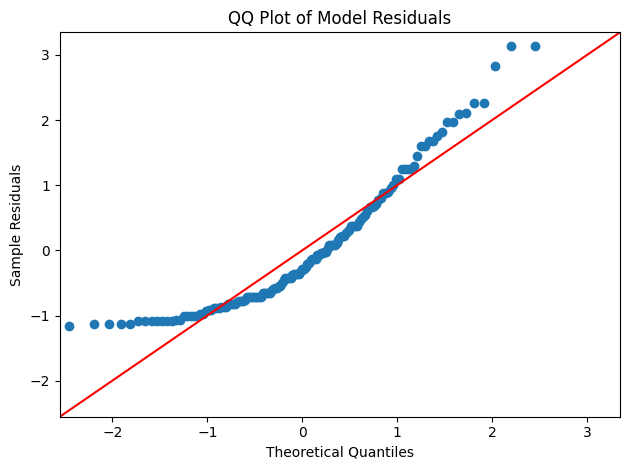

In [ ]:
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Model Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Residuals")
plt.tight_layout()
plt.show()


In [ ]:
### Formal Statistical Tests

from scipy import stats
import numpy as np

print("1. CHI-SQUARE GOODNESS-OF-FIT TEST")
print("="*40)

# Fit Poisson distribution
lambda_hat = seed_data.mean()
print(f"Poisson parameter (λ) estimate: {lambda_hat:.3f}")

# Calculate expected frequencies under Poisson
unique_values = np.arange(0, seed_data.max() + 1)
expected_poisson = len(seed_data) * stats.poisson.pmf(unique_values, lambda_hat)

# Get observed frequencies
observed_freq = np.bincount(seed_data.astype(int), minlength=len(unique_values))

# Combine bins with expected frequency < 5 for valid chi-square test
def combine_small_bins(observed, expected, min_expected=5):
    combined_obs = []
    combined_exp = []
    temp_obs = 0
    temp_exp = 0
    
    for i in range(len(observed)):
        temp_obs += observed[i]
        temp_exp += expected[i]
        
        if temp_exp >= min_expected or i == len(observed) - 1:
            combined_obs.append(temp_obs)
            combined_exp.append(temp_exp)
            temp_obs = 0
            temp_exp = 0
    
    return np.array(combined_obs), np.array(combined_exp)

obs_combined, exp_poisson_combined = combine_small_bins(observed_freq, expected_poisson)

# Chi-square test for Poisson
chi2_poisson, p_poisson = stats.chisquare(obs_combined, exp_poisson_combined, ddof=1)  # ddof=1 because we estimated λ

print(f"Chi-square statistic (Poisson): {chi2_poisson:.4f}")
print(f"p-value (Poisson): {p_poisson:.30f}")
print(f"Degrees of freedom: {len(obs_combined) - 1 - 1}")  # bins - 1 - estimated parameters

if p_poisson < 0.05:
    print("Result: REJECT Poisson distribution (p < 0.05)")
else:
    print("Result: FAIL TO REJECT Poisson distribution (p >= 0.05)")


1. CHI-SQUARE GOODNESS-OF-FIT TEST
Poisson parameter (λ) estimate: 19.206
Chi-square statistic (Poisson): 692.0654
p-value (Poisson): 0.000000000000000000000000000000
Degrees of freedom: 13
Result: REJECT Poisson distribution (p < 0.05)


In [ ]:
formula = "seed ~ flower_size_norm * treatment + tunnel_volume_norm * treatment + black_patch_norm * treatment + population + (1|genotype_id)"
seed_count_model_r = glmer(formula, data=df_fruitful_r)

In [ ]:
seed_count_model_r.fit(
    r_fn='glmer.nb',
    # conf_int='wald', # Use 'wald' for glmm confidence intervals
    REML=False,      # GLMMs are fit with ML, not REML
    r_library="lme4" # Explicitly tell pymer4 which R library to use
)

In [ ]:
r_model = seed_count_model_r.r_model

In [ ]:
from rpy2.robjects import r
summary_output = r.summary(r_model)
summary_output

<rpy2.robjects.vectors.ListVector object at 0x0000018D9AE5A510> [19]
R classes: ('summary.merMod',)
[StrSexpVe..., StrSexpVe..., ListSexpV..., BoolSexpV..., ..., FloatSexp..., StrSexpVe..., ListSexpV..., BoolSexpV...]
  methTitle: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000018D9AC9FDD0> [16]
R classes: ('character',)
['Linear mixed model fit by REML']
  objClass: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000018D9AF25FD0> [16]
R classes: ('character',)
['lmerMod']
<rpy2.robjects.vectors.ListVector object at 0x0000018D9AE5A510> [19]
R classes: ('summary.merMod',)
[StrSexpVe..., StrSexpVe..., ListSexpV..., BoolSexpV..., ..., FloatSexp..., StrSexpVe..., ListSexpV..., BoolSexpV...]
  isLmer: <class 'rpy2.robjects.vectors.BoolVector'>
  <rpy2.robjects.vectors.BoolVector object at 0x0000018D9AE1A410> [10]
R classes: ('logical',)
[       1]
...
  logLik: <class 'rpy2.robjects.vectors.FloatVector'>
  <rpy2.robjects.vectors.FloatVector object at 0x0000018D9AF26E90> [14]
R classes: ('numeric',)
[-1.075740, 2.277632, 0.882790, 0.296951, ..., -0.010809, 0.425289, 0.106437, 0.021178]
  family: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x0000018D9ADF8950> [16]
R classes: ('character',)
[]
<rpy2.robjects.vectors.ListVector object at 0x0000018D9AE5A510> [19]
R classes: ('summary.merMod',)
[StrSexpVe..., StrSexpVe..., ListSexpV..., BoolSexpV..., ..., FloatSexp..., StrSexpVe..., ListSexpV..., BoolSexpV...]
  ngrps: <class 'rpy2.robjects.vectors.BoolVector'>
  <rpy2.robjects.vectors.BoolVector object at 0x0000018D9AF27ED0> [10]
R classes: ('logical',)
[NA]

In [ ]:
import polars as pl
import numpy as np
from scipy.stats import norm

# Assume 'summary_output' is the ListVector you already have from the model fit

# --- PARSING THE R SUMMARY OBJECT AND CALCULATING P-VALUES ---

# 1. Extract the R matrix object containing the coefficients (which has 3 columns)
coeffs_matrix_r = summary_output.rx2('coefficients')

# 2. Convert the R matrix into a NumPy array.
data_numpy = np.array(coeffs_matrix_r)

# 3. Get the term names from the R matrix's row names.
term_names = list(coeffs_matrix_r.rownames)

# 4. Create the Polars DataFrame using the CORRECT 3-column schema.
#    This will now work without a ValueError.
coeffs_df_pl = pl.DataFrame(
    data_numpy,
    schema=['Estimate', 'SE', 'Z-stat']
)

# 5. Add the 'Term' column.
coeffs_df_pl = coeffs_df_pl.with_columns(
    pl.Series("Term", term_names)
)

# 6. --- CRUCIAL STEP: CALCULATE THE P-VALUE ---
#    The p-value for a two-tailed z-test is 2 * (1 - CDF(abs(z))).
#    We use scipy.stats.norm.cdf for the Cumulative Distribution Function.
coeffs_df_pl = coeffs_df_pl.with_columns(
    (2 * (1 - pl.col("Z-stat").abs().map_elements(norm.cdf, return_dtype=pl.Float64)))
    .alias("p-value")
)

# 7. Reorder the columns for the final presentation.
coeffs_df_pl = coeffs_df_pl.select(
    "Term", "Estimate", "SE", "Z-stat", "p-value"
)

print("--- Negative Binomial Model Results (p-values calculated manually) ---")
print(coeffs_df_pl)



--- Negative Binomial Model Results (p-values calculated manually) ---
shape: (9, 5)
┌─────────────────────────────────┬───────────┬──────────┬───────────┬──────────┐
│ Term                            ┆ Estimate  ┆ SE       ┆ Z-stat    ┆ p-value  │
│ ---                             ┆ ---       ┆ ---      ┆ ---       ┆ ---      │
│ str                             ┆ f64       ┆ f64      ┆ f64       ┆ f64      │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════╪══════════╡
│ (Intercept)                     ┆ 19.589633 ┆ 2.090803 ┆ 9.36943   ┆ 0.0      │
│ flower_size_norm                ┆ 0.51408   ┆ 1.854933 ┆ 0.277142  ┆ 0.781671 │
│ treatmentTREATMENT              ┆ -1.778793 ┆ 4.629476 ┆ -0.384232 ┆ 0.700806 │
│ tunnel_volume_norm              ┆ 4.858117  ┆ 1.71273  ┆ 2.836477  ┆ 0.004561 │
│ black_patch_norm                ┆ 0.161482  ┆ 1.585691 ┆ 0.101837  ┆ 0.918886 │
│ populationNET                   ┆ 1.026734  ┆ 3.975447 ┆ 0.258269  ┆ 0.796199 │
│ flower_size

In [ ]:
# Get Random Effects variance
varcor_r = summary_output.rx2('varcor')
ranef_matrix_r = varcor_r.rx2('genotype_id')
ranef_variance = np.array(ranef_matrix_r)[0, 0]

print(f"\n--- Random Effects ---")
print(f"Variance of Genotype_ID (Intercept): {ranef_variance:.4f}")


--- Random Effects ---
Variance of Genotype_ID (Intercept): 27.2445


In [ ]:
# # Get the Theta (dispersion) parameter
# family_info = summary_output.rx2('family')
# theta = family_info.rx2('theta')[0]

# print(f"\nDispersion Parameter (Theta): {theta:.4f}")
# print("(A smaller Theta indicates greater overdispersion)")

In [ ]:

# --- Extract and print the other key model statistics (this part is unchanged) ---

# Get AIC, BIC, and Log-Likelihood
aic = summary_output.rx2('AICtab')[0]
# bic = summary_output.rx2('AICtab')[1]
# loglik = summary_output.rx2('AICtab')[2]

print(f"\nAIC: {aic:.2f}")
# print(f"BIC: {bic:.2f}")
# print(f"Log-Likelihood: {loglik:.2f}")



AIC: 1125.35


## More Formulas

In [ ]:
formula_model_1 = "seed ~ (flower_size_norm + tunnel_volume_norm + black_patch_norm + flower_size_norm:tunnel_volume_norm + flower_size_norm:black_patch_norm + tunnel_volume_norm:black_patch_norm) * treatment + population + (1|genotype_id)"
formula_model_2 = "seed ~ (flower_size_norm + tunnel_volume_norm + black_patch_norm + I(flower_size_norm^2) + I(tunnel_volume_norm^2) + I(black_patch_norm^2)) * treatment + population + (1|genotype_id)"
formula_model_3 = "seed ~ (flower_size_norm + tunnel_volume_norm + black_patch_norm + flower_size_norm:tunnel_volume_norm + flower_size_norm:black_patch_norm + tunnel_volume_norm:black_patch_norm + I(flower_size_norm^2) + I(tunnel_volume_norm^2) + I(black_patch_norm^2)) * treatment + population + (1|genotype_id)"

In [ ]:
seed_count_model_r = glmer(formula_model_1, data=df_fruitful_r)
seed_count_model_r.fit(
    r_fn='glmer.nb',
    # conf_int='wald', # Use 'wald' for glmm confidence intervals
    REML=False,      # GLMMs are fit with ML, not REML
    r_library="lme4" # Explicitly tell pymer4 which R library to use
)
r_model = seed_count_model_r.r_model
summary_output = r.summary(r_model)


# --- PARSING THE R SUMMARY OBJECT AND CALCULATING P-VALUES ---

# 1. Extract the R matrix object containing the coefficients (which has 3 columns)
coeffs_matrix_r = summary_output.rx2('coefficients')

# 2. Convert the R matrix into a NumPy array.
data_numpy = np.array(coeffs_matrix_r)

# 3. Get the term names from the R matrix's row names.
term_names = list(coeffs_matrix_r.rownames)

# 4. Create the Polars DataFrame using the CORRECT 3-column schema.
#    This will now work without a ValueError.
coeffs_df_pl = pl.DataFrame(
    data_numpy,
    schema=['Estimate', 'SE', 'Z-stat']
)

# 5. Add the 'Term' column.
coeffs_df_pl = coeffs_df_pl.with_columns(
    pl.Series("Term", term_names)
)

# 6. --- CRUCIAL STEP: CALCULATE THE P-VALUE ---
#    The p-value for a two-tailed z-test is 2 * (1 - CDF(abs(z))).
#    We use scipy.stats.norm.cdf for the Cumulative Distribution Function.
coeffs_df_pl = coeffs_df_pl.with_columns(
    (2 * (1 - pl.col("Z-stat").abs().map_elements(norm.cdf, return_dtype=pl.Float64)))
    .alias("p-value")
)

# 7. Reorder the columns for the final presentation.
coeffs_df_pl = coeffs_df_pl.select(
    "Term", "Estimate", "SE", "Z-stat", "p-value"
)

print("--- Negative Binomial Model Results (p-values calculated manually) ---")
print(coeffs_df_pl)



--- Negative Binomial Model Results (p-values calculated manually) ---
shape: (15, 5)
┌─────────────────────────────────┬───────────┬──────────┬───────────┬──────────┐
│ Term                            ┆ Estimate  ┆ SE       ┆ Z-stat    ┆ p-value  │
│ ---                             ┆ ---       ┆ ---      ┆ ---       ┆ ---      │
│ str                             ┆ f64       ┆ f64      ┆ f64       ┆ f64      │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════╪══════════╡
│ (Intercept)                     ┆ 19.780285 ┆ 2.163905 ┆ 9.141014  ┆ 0.0      │
│ flower_size_norm                ┆ 0.486728  ┆ 1.962258 ┆ 0.248045  ┆ 0.804099 │
│ tunnel_volume_norm              ┆ 5.088592  ┆ 1.790962 ┆ 2.841261  ┆ 0.004494 │
│ black_patch_norm                ┆ 0.371273  ┆ 1.627017 ┆ 0.228193  ┆ 0.819496 │
│ treatmentTREATMENT              ┆ -3.171939 ┆ 5.04541  ┆ -0.628678 ┆ 0.52956  │
│ …                               ┆ …         ┆ …        ┆ …         ┆ …        │
│ tunnel_vol

In [ ]:
seed_count_model_r = glmer(formula_model_2, data=df_fruitful_r)
seed_count_model_r.fit(
    r_fn='glmer.nb',
    # conf_int='wald', # Use 'wald' for glmm confidence intervals
    REML=False,      # GLMMs are fit with ML, not REML
    r_library="lme4" # Explicitly tell pymer4 which R library to use
)
r_model = seed_count_model_r.r_model
summary_output = r.summary(r_model)


# --- PARSING THE R SUMMARY OBJECT AND CALCULATING P-VALUES ---

# 1. Extract the R matrix object containing the coefficients (which has 3 columns)
coeffs_matrix_r = summary_output.rx2('coefficients')

# 2. Convert the R matrix into a NumPy array.
data_numpy = np.array(coeffs_matrix_r)

# 3. Get the term names from the R matrix's row names.
term_names = list(coeffs_matrix_r.rownames)

# 4. Create the Polars DataFrame using the CORRECT 3-column schema.
#    This will now work without a ValueError.
coeffs_df_pl = pl.DataFrame(
    data_numpy,
    schema=['Estimate', 'SE', 'Z-stat']
)

# 5. Add the 'Term' column.
coeffs_df_pl = coeffs_df_pl.with_columns(
    pl.Series("Term", term_names)
)

# 6. --- CRUCIAL STEP: CALCULATE THE P-VALUE ---
#    The p-value for a two-tailed z-test is 2 * (1 - CDF(abs(z))).
#    We use scipy.stats.norm.cdf for the Cumulative Distribution Function.
coeffs_df_pl = coeffs_df_pl.with_columns(
    (2 * (1 - pl.col("Z-stat").abs().map_elements(norm.cdf, return_dtype=pl.Float64)))
    .alias("p-value")
)

# 7. Reorder the columns for the final presentation.
coeffs_df_pl = coeffs_df_pl.select(
    "Term", "Estimate", "SE", "Z-stat", "p-value"
)

print("--- Negative Binomial Model Results (p-values calculated manually) ---")
print(coeffs_df_pl)



--- Negative Binomial Model Results (p-values calculated manually) ---
shape: (15, 5)
┌─────────────────────────────────┬───────────┬──────────┬───────────┬────────────┐
│ Term                            ┆ Estimate  ┆ SE       ┆ Z-stat    ┆ p-value    │
│ ---                             ┆ ---       ┆ ---      ┆ ---       ┆ ---        │
│ str                             ┆ f64       ┆ f64      ┆ f64       ┆ f64        │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════╪════════════╡
│ (Intercept)                     ┆ 21.87777  ┆ 3.046122 ┆ 7.182172  ┆ 6.8612e-13 │
│ flower_size_norm                ┆ 1.9118    ┆ 2.156191 ┆ 0.886656  ┆ 0.375264   │
│ tunnel_volume_norm              ┆ 4.594212  ┆ 1.739009 ┆ 2.641857  ┆ 0.008245   │
│ black_patch_norm                ┆ 0.595116  ┆ 1.762634 ┆ 0.337629  ┆ 0.735643   │
│ I(flower_size_norm^2)           ┆ -1.209513 ┆ 0.909253 ┆ -1.330227 ┆ 0.183444   │
│ …                               ┆ …         ┆ …        ┆ …         ┆ …  

In [ ]:
seed_count_model_r = glmer(formula_model_3, data=df_fruitful_r)
seed_count_model_r.fit(
    r_fn='glmer.nb',
    # conf_int='wald', # Use 'wald' for glmm confidence intervals
    REML=False,      # GLMMs are fit with ML, not REML
    r_library="lme4" # Explicitly tell pymer4 which R library to use
)
r_model = seed_count_model_r.r_model
summary_output = r.summary(r_model)


# --- PARSING THE R SUMMARY OBJECT AND CALCULATING P-VALUES ---

# 1. Extract the R matrix object containing the coefficients (which has 3 columns)
coeffs_matrix_r = summary_output.rx2('coefficients')

# 2. Convert the R matrix into a NumPy array.
data_numpy = np.array(coeffs_matrix_r)

# 3. Get the term names from the R matrix's row names.
term_names = list(coeffs_matrix_r.rownames)

# 4. Create the Polars DataFrame using the CORRECT 3-column schema.
#    This will now work without a ValueError.
coeffs_df_pl = pl.DataFrame(
    data_numpy,
    schema=['Estimate', 'SE', 'Z-stat']
)

# 5. Add the 'Term' column.
coeffs_df_pl = coeffs_df_pl.with_columns(
    pl.Series("Term", term_names)
)

# 6. --- CRUCIAL STEP: CALCULATE THE P-VALUE ---
#    The p-value for a two-tailed z-test is 2 * (1 - CDF(abs(z))).
#    We use scipy.stats.norm.cdf for the Cumulative Distribution Function.
coeffs_df_pl = coeffs_df_pl.with_columns(
    (2 * (1 - pl.col("Z-stat").abs().map_elements(norm.cdf, return_dtype=pl.Float64)))
    .alias("p-value")
)

# 7. Reorder the columns for the final presentation.
coeffs_df_pl = coeffs_df_pl.select(
    "Term", "Estimate", "SE", "Z-stat", "p-value"
)

print("--- Negative Binomial Model Results (p-values calculated manually) ---")
print(coeffs_df_pl)



--- Negative Binomial Model Results (p-values calculated manually) ---
shape: (21, 5)
┌─────────────────────────────────┬───────────┬──────────┬───────────┬────────────┐
│ Term                            ┆ Estimate  ┆ SE       ┆ Z-stat    ┆ p-value    │
│ ---                             ┆ ---       ┆ ---      ┆ ---       ┆ ---        │
│ str                             ┆ f64       ┆ f64      ┆ f64       ┆ f64        │
╞═════════════════════════════════╪═══════════╪══════════╪═══════════╪════════════╡
│ (Intercept)                     ┆ 22.515666 ┆ 3.108251 ┆ 7.243838  ┆ 4.3610e-13 │
│ flower_size_norm                ┆ 1.960966  ┆ 2.177575 ┆ 0.900527  ┆ 0.36784    │
│ tunnel_volume_norm              ┆ 5.209487  ┆ 1.798874 ┆ 2.895972  ┆ 0.00378    │
│ black_patch_norm                ┆ 1.103887  ┆ 1.799101 ┆ 0.613577  ┆ 0.539495   │
│ I(flower_size_norm^2)           ┆ -1.833985 ┆ 1.093799 ┆ -1.676711 ┆ 0.093599   │
│ …                               ┆ …         ┆ …        ┆ …         ┆ …  

In [ ]:
# --- DIAGNOSTIC WORKFLOW SCRIPT (Corrected) ---

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter

# --- 1. THE MAIN DIAGNOSTIC FUNCTION (Corrected) ---
def run_full_diagnostics(formula_str, model_name, data_r):
    """
    Fits a glmer.nb model and runs a full diagnostic suite,
    including DHARMa tests and plots.
    """
    print(f"\n{'='*80}")
    print(f"RUNNING FULL DIAGNOSTICS FOR: {model_name}")
    print(f"{'='*80}")

    # --- Step 1: Fit Model & Check Convergence ---
    print("\n[Step 1] Fitting model and checking for convergence warnings...")
    model = glmer(formula_str, data=data_r, family='gaussian') # Placeholder

    model.fit(
                r_fn='glmer.nb',
                # conf_int='wald', # Use 'wald' for glmm confidence intervals
                REML=False,      # GLMMs are fit with ML, not REML
                r_library="lme4" # Explicitly tell pymer4 which R library to use
                )

    r_model = model.r_model
    # --- Step 2: Run DHARMa Diagnostics ---
    print("\n[Step 2] Running DHARMa diagnostics in R...")
    r('library(DHARMa)')
    r_model_name = "r_model"
    r.assign(r_model_name, r_model) # Make the model available in R's global env
    
    # Simulate residuals (suppress R plot popup by setting plot=FALSE)
    r_command_simulate = f"simulationOutput <- simulateResiduals(fittedModel = {r_model_name}, plot = FALSE)"
    r(r_command_simulate)
    
    # Run DHARMa tests
    print("\n--- DHARMa Test Results ---")
    print("Dispersion Test:")
    disp_test = r('testDispersion(simulationOutput)')
    print(disp_test)

    # --- Step 3: Plot DHARMa Residuals (Python only) ---
    print("\n[Step 3] Generating DHARMa residual plots (Python)...")
    
    # Get simulated residuals and predicted values from R
    simulated_residuals = np.array(r('simulationOutput$scaledResiduals'))
    with localconverter(pandas2ri.converter):
        predicted_values = r('predict(r_model, type="response")')
        predicted_values_py = np.array(predicted_values)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'DHARMa Diagnostic Plots for {model_name}', fontsize=16)

    # QQ Plot
    stats.probplot(simulated_residuals, dist="uniform", plot=axes[0])
    axes[0].set_title('QQ Plot of Scaled Residuals')
    axes[0].set_xlabel('Uniform Quantiles')
    axes[0].set_ylabel('Residual Quantiles')

    # Residuals vs. Predicted Plot
    axes[1].scatter(predicted_values_py, simulated_residuals, alpha=0.5)
    axes[1].axhline(y=0.5, color='red', linestyle='--')
    axes[1].set_title('Residuals vs. Predicted Values')
    axes[1].set_xlabel('Predicted Seed Count')
    axes[1].set_ylabel('Scaled Residuals')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Step 4: Check Distribution of Random Effects ---
    print("\n[Step 4] Checking distribution of random effects...")
    
    # Extract random effects (BLUPs)
    ranef_r = r.ranef(r_model)[0] # Get the first random effect term
    with localconverter(pandas2ri.converter):
        ranef_py = np.array(ranef_r).flatten()

    fig, ax = plt.subplots(figsize=(7, 6))
    stats.probplot(ranef_py, dist="norm", plot=ax)
    ax.set_title(f'QQ Plot of Random Intercepts (genotype_id) for {model_name}')
    plt.show()
    axes[1].set_title('Residuals vs. Predicted Values')
    axes[1].set_xlabel('Predicted Seed Count')
    axes[1].set_ylabel('Scaled Residuals')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Step 4: Check Distribution of Random Effects ---
    print("\n[Step 4] Checking distribution of random effects...")
    
    # Extract random effects (BLUPs)
    ranef_r = r.ranef(r_model)[0] # Get the first random effect term
    with localconverter(pandas2ri.converter):
        ranef_py = np.array(ranef_r).flatten()

    fig, ax = plt.subplots(figsize=(7, 6))
    stats.probplot(ranef_py, dist="norm", plot=ax)
    ax.set_title(f'QQ Plot of Random Intercepts (genotype_id) for {model_name}')
    plt.show()




RUNNING FULL DIAGNOSTICS FOR: Model 0: Baseline (Directional)

[Step 1] Fitting model and checking for convergence warnings...

[Step 2] Running DHARMa diagnostics in R...

--- DHARMa Test Results ---
Dispersion Test:


[Step 3] Generating DHARMa residual plots (Python)...


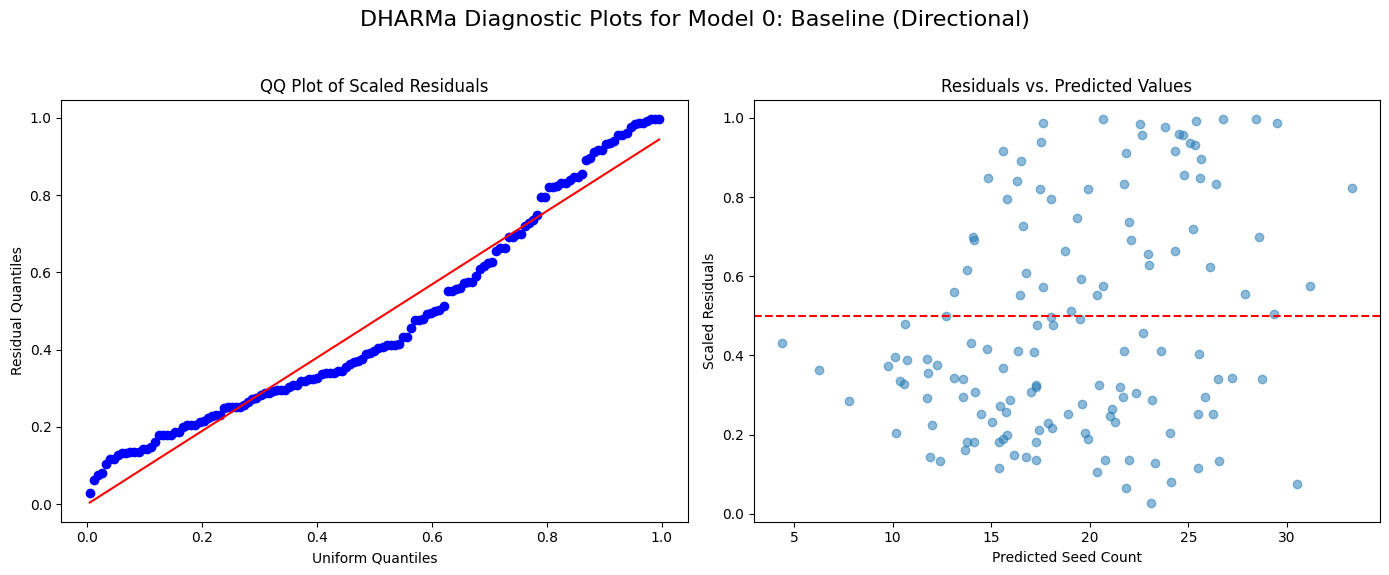


[Step 4] Checking distribution of random effects...


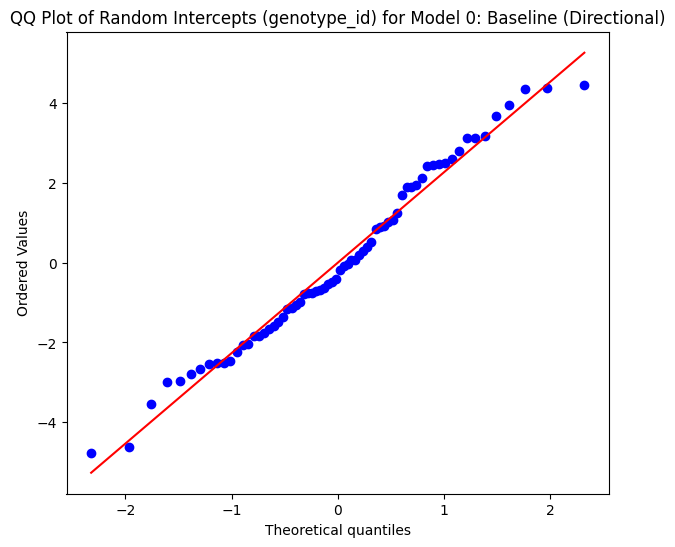

<Figure size 640x480 with 0 Axes>


[Step 4] Checking distribution of random effects...


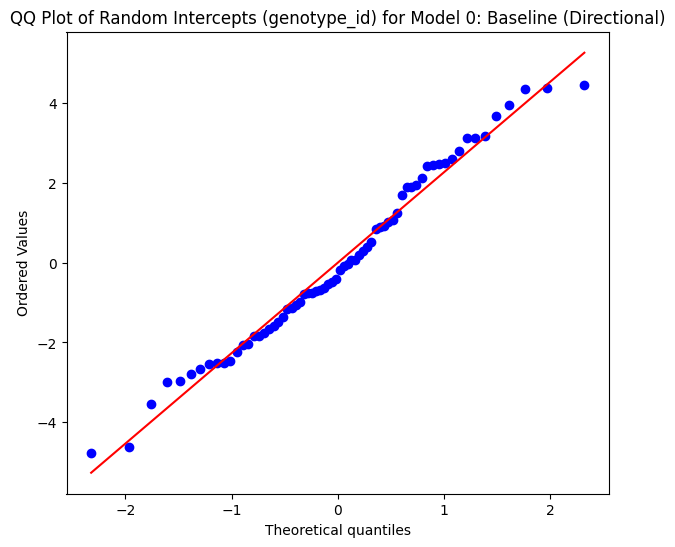

In [ ]:

# Define the formula for the model you want to diagnose
formula_to_diagnose = "seed ~ flower_size_norm * treatment + tunnel_volume_norm * treatment + black_patch_norm * treatment + population + (1|genotype_id)"
model_name_to_diagnose = "Model 0: Baseline (Directional)"

# Run the full diagnostic workflow
run_full_diagnostics(formula_to_diagnose, model_name_to_diagnose, df_fruitful_r)